# <center> **Predict if a Patient is Likely to Suffer from a Stroke**

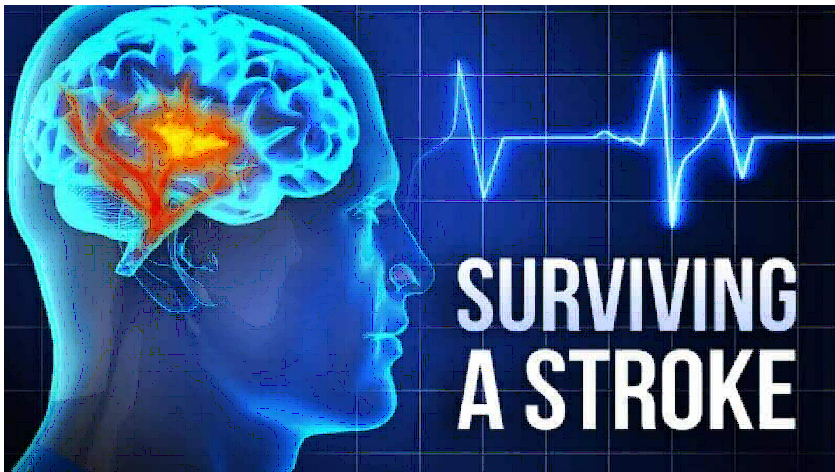

# **Introduction**

A stroke, occurs when the blood supply to part of the brain is disrupted or reduced, depriving brain tissue of oxygen and nutrients. This can happen due to a blockage or rupture of a blood vessel. Without prompt medical attention, strokes can cause permanent brain damage or even death. Immediate treatment is crucial to minimize damage and improve outcomes for stroke patients.

It will become evident in this analysis that the data is extremely limited. Predicting a complex disease like a storke with such basic information as marital status or residence is simply laughable. In the end, the only predictor worth really looking at was age, which is the most obvious answer, but lacking better information, this is the best that can be done with this data.

# **Dataset**

The "Stroke Prediction Dataset" from Kaggle is a dataset designed to predict whether a patient is likely to have a stroke based on various health and demographic factors. It contains several features including demographic information (age, gender), health parameters (hypertension, heart disease), lifestyle factors (smoking status), and medical history  (glucose and BMI levels). The target variable indicates whether a person has had a stroke or not.

# **Goal**

For this project, I picked recall for evaluating my models. My goal in this analysis is to understand the factors can predict a patient suffering a stroke and to build predictive models for stroke occurrence with a recall score of 75% or higher.Recall measures how well a model identifies all actual positive cases (like patients with a disease). It is the percentage of true positive results out of all the actual positives. For example, if 100 patients truly have a disease and the model correctly identifies 90 of them, the recall is 90%. High recall means the model is good at detecting the condition whenever it is present. 

# **Technical Requirements**

1. Perform exploratory data analysis. 
2. Perform statistical inference. 
3. Apply various machine learning models to predict the occurance of stroke. 
4. Provide clear explanations. 
5. Provide suggestions about how the analysis can be improved.

# **Standards**

> **Standard 1:** My standard for an acceptable recall score is 75% or higher .<BR>
> **Standard 2:** My significance level (alpha) for all hypothesis tests is 0.05. <BR>
> **Standard 3:** My standard for a strong correlation between features is a Pearson correlation coefficient of 0.8 or higher. <BR>    

# **Biases**

The main bias in this dataset was that it is highly imbalanced. Out of 5,000 patients, there are only 249 who suffered a stroke. This is a good for the patients, but it makes it difficult to build a good predictive model. 

# **Domain Knowledge**

Although I have some scientific knowlege, I have no medical experience. I may have overlooked parts of the data that may have been most important and I may have given importance to parts that may have had little significance. 

# **Libraries**

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from feature_engine.imputation import AddMissingIndicator
from feature_engine.imputation import MeanMedianImputer

from feature_engine.encoding import OneHotEncoder

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.proportion import proportions_ztest
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

from scipy import stats

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC


from sklearn.metrics import make_scorer, recall_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from autofeat import AutoFeatClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier 

from sklearn.utils.class_weight import compute_class_weight

from sklearn.feature_selection import SelectKBest, f_classif

from feature_engine.imputation import AddMissingIndicator
from feature_engine.imputation import RandomSampleImputer
from feature_engine.creation import MathFeatures

from sklearn.metrics import accuracy_score, recall_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from feature_engine.selection import DropCorrelatedFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV



import shap
import optuna
import pickle
import warnings

# **Display Parameters**

## **Display Features**

In [2]:
%matplotlib inline

pd.options.display.max_rows = 300000
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 500

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

## **Colors**

In [3]:
color_1 = "bisque"
color_2 = "crimson"
color_3 = "orangered"
color_4 = "lightcoral"
color_5 = "royalblue"
color_6 = "pink"
color_7 = "indianred"
color_8 = "slategrey"
color_9 = "salmon"
color_10 = "beige"
color_11 = "coral"
color_13 = "grey"
color_14 = "tan"
color_15 = "wheat"
color_16 = "tomato"

## **Figure Parameters**

In [4]:
size = 20

params = {
    "font.family": "Times New Roman",
    "font.size": size,
    "axes.labelsize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "figure.titlesize": size * 1.5,
    "axes.titlesize": size * 1.5,
    "axes.titlepad": size,
    "axes.labelpad": size - 10,
    "lines.linewidth": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "legend.fontsize": size,
    "figure.figsize": (10, 6),
}

# **Data Overview and Preprocessing**

In [5]:
data = pd.read_csv(
    r"C:\Users\Dell\Documents\Stroke\Data\stroke.csv",
    index_col=0
)

target = 'Stroke'

In [6]:
data.head()

,ID,Gender,Age,Hypertension,Heart Disease,Ever Married,Work,Residence,AVG Glucose,BMI,Smoking,Stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## **Number of Rows and Columns**

In [7]:
data.shape

(5109, 12)

## **Dataset Features**

1. **Gender:** Gender of the patient (Male or Female).
2. **Age:** Age of the patient (float).
3. **Hypertension:** 0 for no hypertension diagnosis. 1 for hypertion diagnosis.
4. **Heart Disease:** 0 for no diagnosis for heart disease. 1 for heart disease diagnosis.
5. **Ever Married:** Yes: The patient has been married or is married. No: The patient has never been married.
6. **Work:** Type of work: Private, Self-Employed, Government, Never Worked, Children (The patient is a child)
7. **Residence:** Two values: Rural, Urban
8. **AVG Glucose:** Average glucose level of the patient.
9. **BMI:** Body Mass Index of the patient.
10. **Smoking:**: Does the patient smoke now or before. Values: Unknown, Formerly Smoked, Never Smokes, Smokes.

## **Missing Data**

In [8]:
data.isnull().sum(axis=0)

ID                 0
Gender             0
Age                0
Hypertension       0
Heart Disease      0
Ever Married       0
Work               0
Residence          0
AVG Glucose        0
BMI              201
Smoking            0
Stroke             0
dtype: int64

## **Duplicate Data**

In [9]:
data[data.duplicated(keep=False)].sum()

ID                 0
Gender             0
Age              0.0
Hypertension       0
Heart Disease      0
Ever Married       0
Work               0
Residence          0
AVG Glucose      0.0
BMI              0.0
Smoking            0
Stroke             0
dtype: object

# **Descriptive Information**

### **Data Types**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             5109 non-null   int64  
 1   Gender         5109 non-null   object 
 2   Age            5109 non-null   float64
 3   Hypertension   5109 non-null   int64  
 4   Heart Disease  5109 non-null   int64  
 5   Ever Married   5109 non-null   object 
 6   Work           5109 non-null   object 
 7   Residence      5109 non-null   object 
 8   AVG Glucose    5109 non-null   float64
 9   BMI            4908 non-null   float64
 10  Smoking        5109 non-null   object 
 11  Stroke         5109 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 518.9+ KB


### **Descriptive Information for Numerical Features**

In [11]:
data.drop(columns=['Stroke']).describe(include="number").applymap("{:,.2f}".format)

,ID,Age,Hypertension,Heart Disease,AVG Glucose,BMI
count,"5,109.00","5,109.00","5,109.00","5,109.00","5,109.00","4,908.00"
mean,"36,513.99",43.23,0.10,0.05,106.14,28.89
std,"21,162.01",22.61,0.30,0.23,45.29,7.85
min,67.00,0.08,0.00,0.00,55.12,10.30
25%,"17,740.00",25.00,0.00,0.00,77.24,23.50
50%,"36,922.00",45.00,0.00,0.00,91.88,28.10
75%,"54,643.00",61.00,0.00,0.00,114.09,33.10
max,"72,940.00",82.00,1.00,1.00,271.74,97.60


### **Descriptive Information for Categorical Features**

In [12]:
data.describe(include="object")

,Gender,Ever Married,Work,Residence,Smoking
count,5109,5109,5109,5109,5109
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2924,2596,1892


### **Outliers**

An outlier is an observation that is unlike the other observations.

I used the **Interquartile Range (IQR)** method to identify outliers. The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot. I chose to show the outliers numerically instead of graphically. I saw more value in this type of presentation.

In [13]:
numeric_data = data.select_dtypes(include=['number'])

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)

IQR = Q3 - Q1

outliers = (numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))

outlier_counts = outliers.sum()
print (outlier_counts)


ID                 0
Age                0
Hypertension     498
Heart Disease    276
AVG Glucose      627
BMI              110
Stroke           249
dtype: int64


### **Section Summary**
> * There are over 5,000 records in this dataset.
> * Of the 10 features, 7 are categorical, and 3 are numerical.  
> * The target is the column 'Stroke', with values 0 or 1. 
> * There are 201 null values in the BMI column. The other 9 columns have no null values.
> * Using the IQR method to identify outliers, I identified outliers in every numerical feature, except Age.  

# **Functions**

Below are the functions that I utilized in this project.

## **Side-by-Side Bar Plots**

In [14]:
def side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette):

    '''
    Creates a side-by-side bar plot comparing two datasets.
    '''

    plt.rcParams.update(params)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.barplot(data=data_1, x=feature, y=y, ax=ax1, palette=palette)
    sns.barplot(data=data_2, x=feature, y=y, ax=ax2, palette=palette)

    ax1.set_xlabel(feature)
    ax1.set_ylabel(y)
    ax2.set_xlabel(feature)
    ax2.set_ylabel(y)

    total_count1 = data_1[y].sum()
    for container in ax1.containers:
        labels = [f'{(v.get_height() / total_count1 * 100):.1f}%' for v in container]
        ax1.bar_label(container, labels=labels, size=size)

    total_count2 = data_2[y].sum()
    for container in ax2.containers:
        labels = [f'{(v.get_height() / total_count2 * 100):.1f}%' for v in container]
        ax2.bar_label(container, labels=labels, size=size)

    ax1.set_title(title_1)
    ax2.set_title(title_2)

    sns.despine()

    plt.show()

## **Distributions**

In [15]:
def create_distributions(data, feature, target, value):

    '''
    Creates a distribution of counts for a specific feature within a subset of data.
    '''
    
    df = data[data[target] == value]
    distribution= df.groupby(feature).size().reset_index()
    distribution.columns = [feature, 'Count']

    return distribution

## **Create Bins**

In [16]:
def create_bins(df, feature, new_feature, bins, labels):

    '''
    Creates bins for continuous features.
    '''

    df[new_feature] = pd.cut(df[feature], bins=bins, labels=labels, right=False)

    return df

## **Count Bins**

In [17]:
def count_bins(df, new_feature):

    '''
    Counts the number of observations in each bin.
    '''
    
    group_counts = df[new_feature].value_counts().sort_index()
    group_counts_df = group_counts.reset_index()
    group_counts_df.columns = [new_feature, 'Count']

    return group_counts_df


## **Heat Map**

In [18]:
def create_heatmap(data, title):

    '''
    Creates a Seaborn heatmap.
    '''

    plt.rcParams.update(params)
    corr = data.corr()

    mask = np.triu(np.ones_like(corr, dtype=bool))

    f, ax = plt.subplots(figsize=(25, 25))

    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    heatmap = sns.heatmap(
        corr,
        mask=mask,
        vmax=1,
        vmin=-1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        cmap=plt.cm.Reds,
    )

    heatmap.set_title(
        title,
        fontdict={"fontsize": size},
        pad=12,
    )
    plt.xlabel("")
    plt.ylabel("")

## **Mutual Information**

In [19]:
def create_plot_mi_scores(features, mi_scores):
    
    '''
    Creates a plot of mutual information scores.
    '''

    plt.rcParams.update({'figure.autolayout': True}) 

    scores = pd.Series(mi_scores, name="MI Scores", index=features.columns)
    scores = scores.sort_values(ascending=False)

    plt.figure(figsize=(15, 6))
    scores.plot(kind="line", marker='o')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.title("Mutual Information Scores")
    plt.xlabel("Feature")
    plt.ylabel("MI Score")

    plt.xticks(ticks=range(len(scores)), labels=scores.index, rotation=45, ha='right')

    plt.tight_layout()

    plt.show()

## **Two-Sample T-Test**

In [21]:
def two_sample_t_test(sample1, sample2, variance):
    
    """
    Determines if the means of two samples are significanlty different.
    """
    
    if variance is False:
        print("The variance of the samples are different.")
    else:
        print("The variance of the samples are the same.")

    result = stats.ttest_ind(sample1, sample2, equal_var=variance)

    p_value = result.pvalue
    
    p_value = "{:.20f}".format(p_value)
    print("The p-value is: ", p_value)

    
    if result.pvalue < 0.05:
        print("Null hypothesis is rejected.")
    else:
        print("Failed to reject the null hypothesis.")

# **Exploratory Data Analysis**

## **Gender**

In this section, I show the distribution of genders among patients who suffered a stroke and those who did not.

In [22]:
feature = 'Gender'
target = 'Stroke'
data = data.copy()  

In [23]:
wi_stroke_gender = create_distributions(data, feature, target, value = 1)

In [24]:
no_stroke_gender = create_distributions(data, feature, target, value = 0)

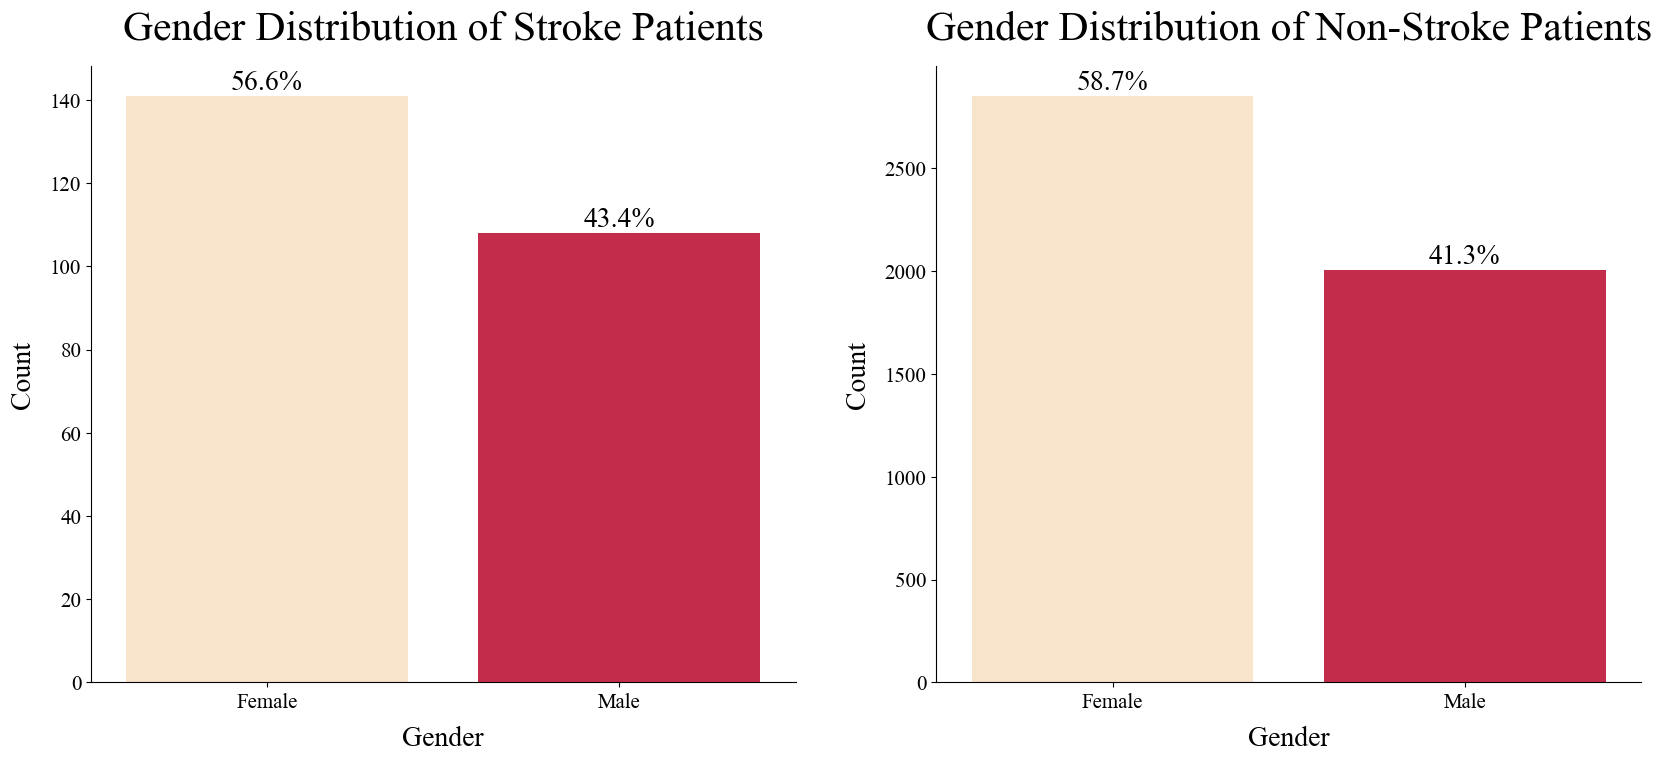

In [25]:
labels = ['Male', 'Female']
palette = [color_1, color_2]
y = 'Count'

data_1 = wi_stroke_gender
data_2 = no_stroke_gender
title_1 = 'Gender Distribution of Stroke Patients'
title_2 = 'Gender Distribution of Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette);

### **Section Summary**
> * Gender distribution is almost the same in patients who suffered a stroke and those who did not. 
> * From this data we can suggest that the medical establishments should look at both genders equally when assessing this ailment.

## **Hypertension**

In [26]:
feature = 'Hypertension'
target = 'Stroke'
data = data.copy()

In [27]:
wi_stroke_hypertension = create_distributions(data, feature, target, value = 1)

In [28]:
no_stroke_hypertension = create_distributions(data, feature, target, value = 0)

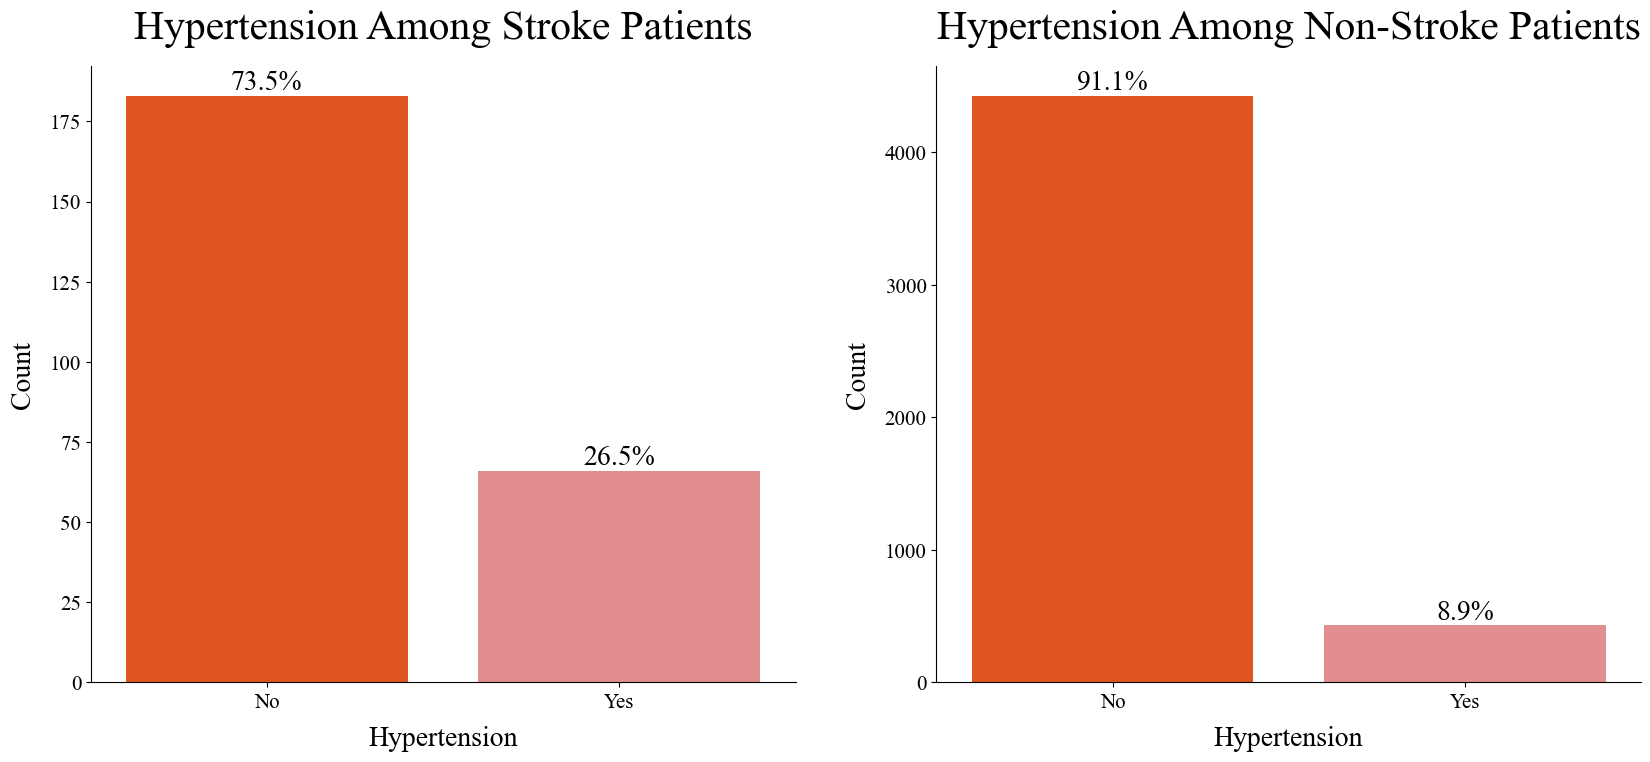

In [29]:
labels = [0, 1]
palette = [color_3, color_4]
y = 'Count'

data_1 = wi_stroke_hypertension.copy() 
data_2 = no_stroke_hypertension.copy()
data_1 ['Hypertension'] = data_1['Hypertension'].replace({0: 'No', 1: 'Yes'})
data_2 ['Hypertension'] = data_2['Hypertension'].replace({0: 'No', 1: 'Yes'})
title_1 = 'Hypertension Among Stroke Patients'
title_2 = 'Hypertension Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette);

### **Section Summary**
> * The percentage of patients with hypertension who also suffered a stroke is more than twice that of patients who did not.  
> * Hypertension may be one of the indicators for a doctor to consider as a possible risk factor when it comes to identifying the likelihood of stroke. 

## **Heart Disease**

In [30]:
feature = 'Heart Disease'
target = 'Stroke'
data = data.copy()

In [31]:
wi_stroke_heart = create_distributions(data, feature, target, value = 1)

In [32]:
no_stroke_heart = create_distributions(data, feature, target, value = 0)

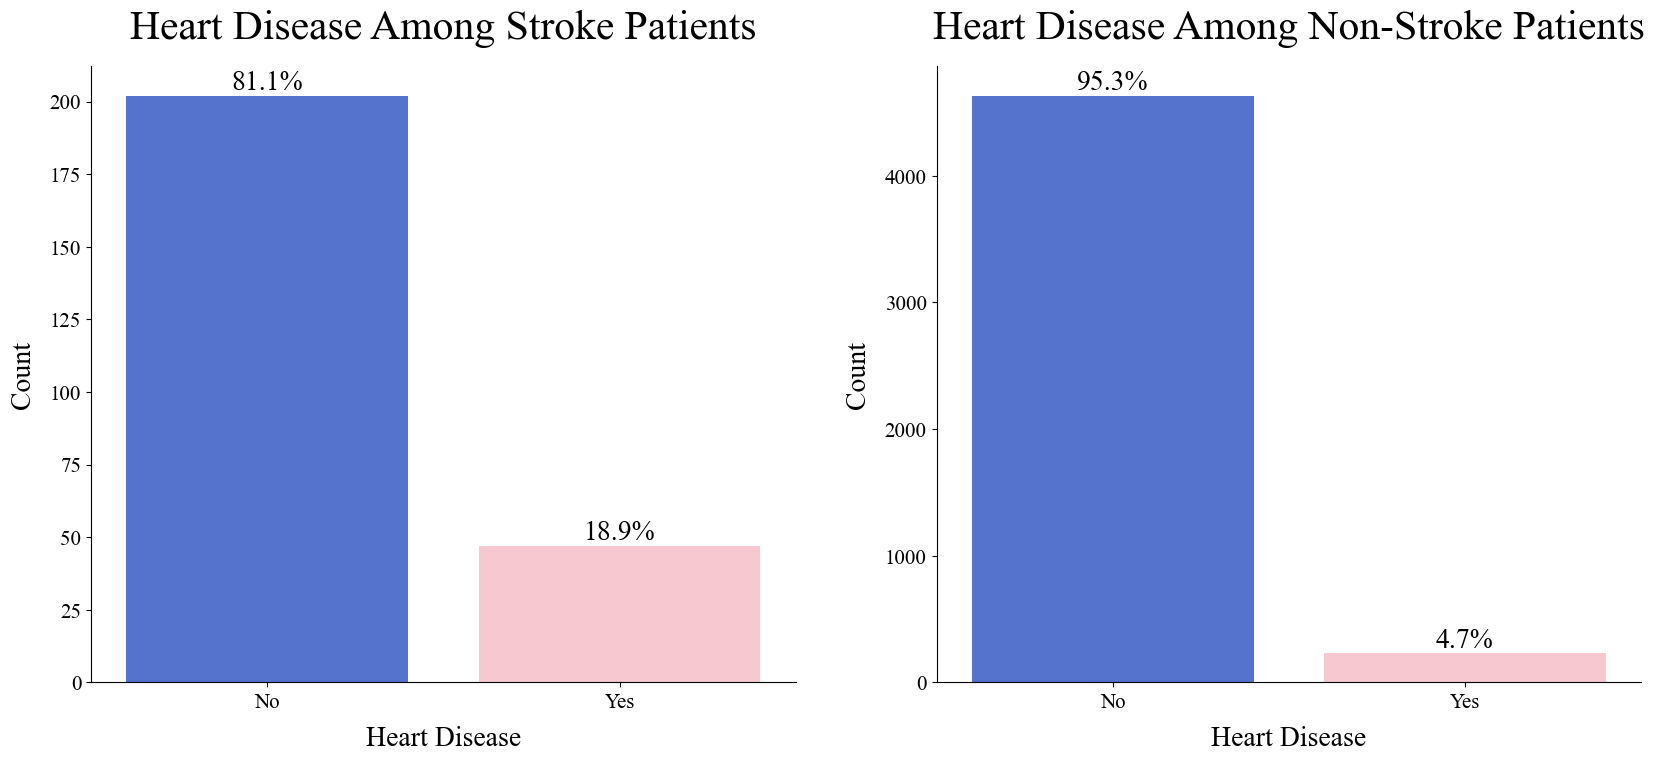

In [33]:
labels = [0, 1]
palette = [color_5, color_6]
y = 'Count'

data_1 = wi_stroke_heart
data_2 = no_stroke_heart 

data_1 ['Heart Disease'] = data_1['Heart Disease'].replace({0: 'No', 1: 'Yes'})
data_2 ['Heart Disease'] = data_2['Heart Disease'].replace({0: 'No', 1: 'Yes'})
title_1 = 'Heart Disease Among Stroke Patients'
title_2 = 'Heart Disease Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette)

### **Section Summary**
> * The percentage of patients with heart disease who also suffered a stroke is more than three times of this number for patients who did not.  
> * Looking at this data, a doctor may consider heart disease as a possible risk factor when it comes to identifying the likelihood of stroke. 

## **Marital Status**

In [34]:
feature = 'Ever Married'
target = 'Stroke'
data = data.copy()

In [35]:
wi_stroke_marriage = create_distributions(data, feature, target, value = 1)

In [36]:
no_stroke_marriage = create_distributions(data, feature, target, value = 0)

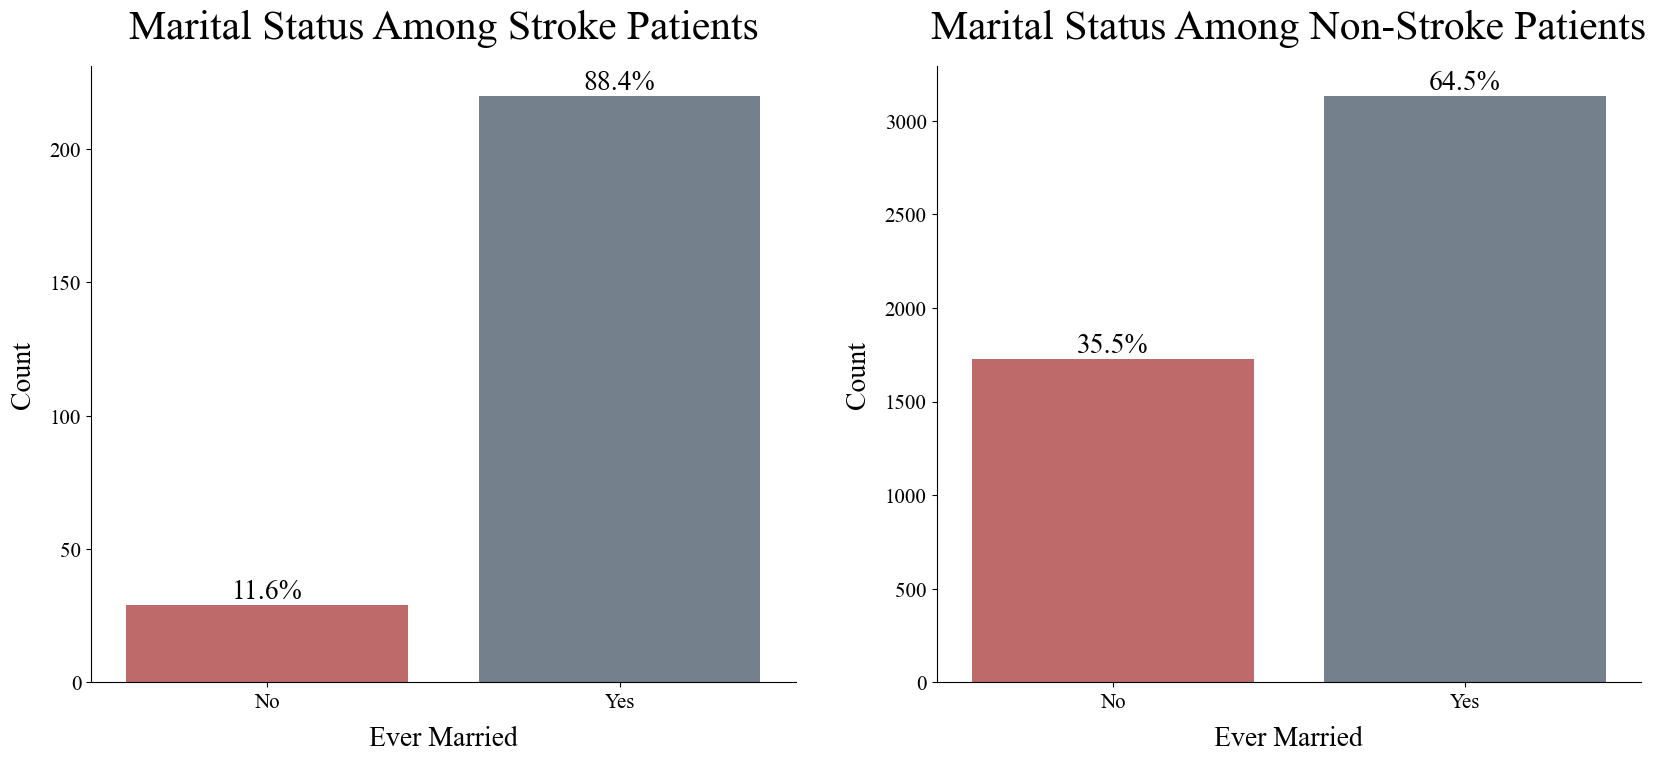

In [37]:
labels = ['No', 'Yes']
palette = [color_7, color_8]
y = 'Count'

data_1 = wi_stroke_marriage
data_2 = no_stroke_marriage
title_1 = 'Marital Status Among Stroke Patients'
title_2 = 'Marital Status Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette)

### **Section Summary**
> * It is an accepted idea that our psychological and social states can affect our biology and our susecptibility to illness.   
> * Why is there nearly 3 times as many non-married people among patients who did not suffer a stroke? 
> * It is hard to say, but it gives us some reasons to look at the marital status of patients and the quality of such a relationship when it comes to identifying risk factors for stroke.

## **Work Status**

In [38]:
feature = 'Work'
target = 'Stroke'
data = data.copy()

In [39]:
wi_stroke_work = create_distributions(data, feature, target, value = 1)

In [40]:
no_stroke_work = create_distributions(data, feature, target, value = 0)

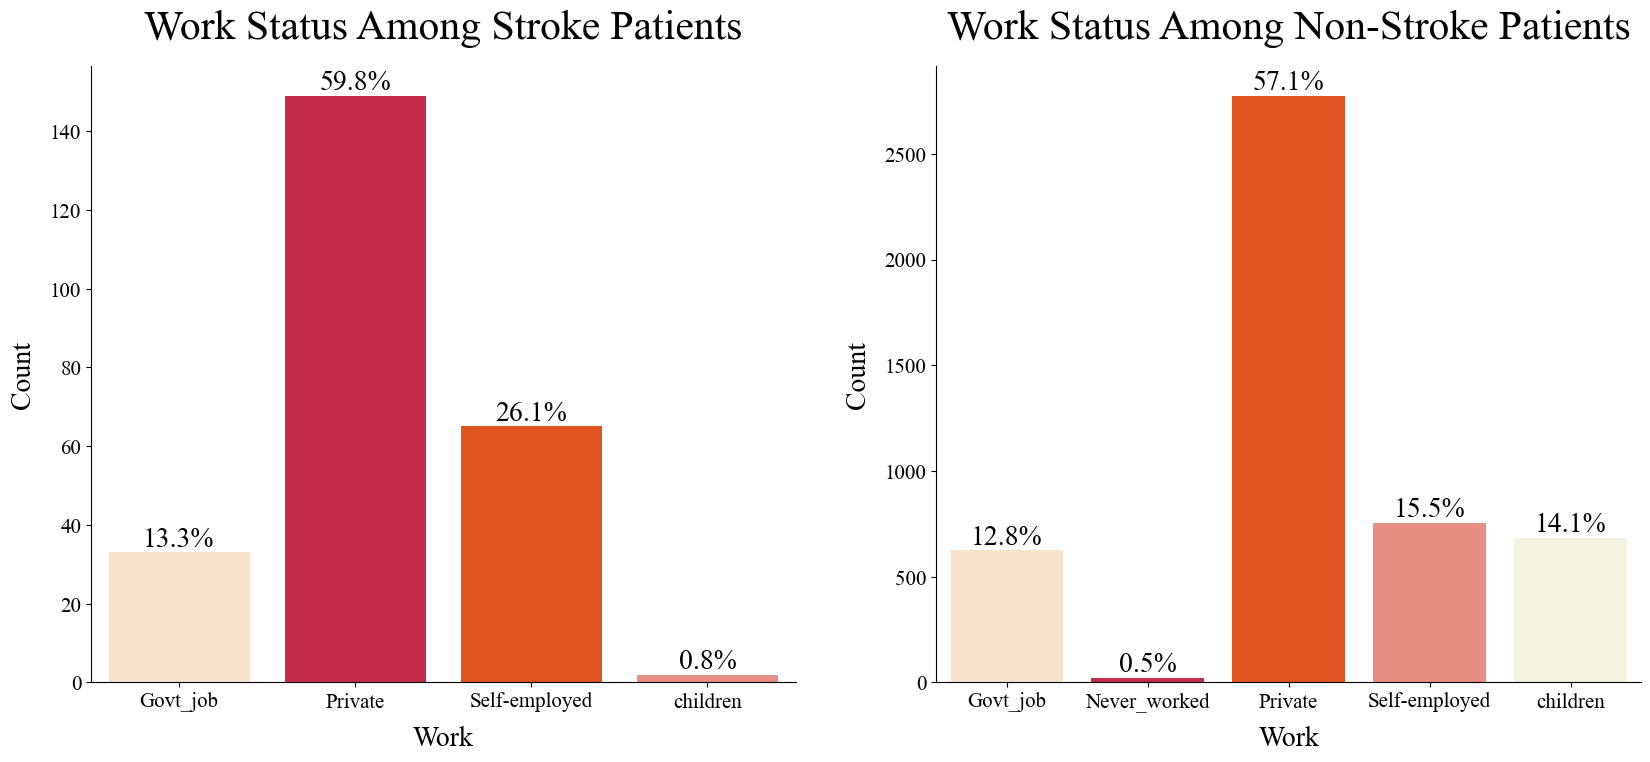

In [41]:
labels = ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
palette = [color_1, color_2, color_3, color_9, color_10]
y = 'Count'

data_1 = wi_stroke_work
data_2 = no_stroke_work
title_1 = 'Work Status Among Stroke Patients'
title_2 = 'Work Status Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette)

### **Section Summary**
> * The only significant difference here is that a big percentage of those who did not suffer a stroke are those too young to work. 
> * This will be significant later in the analysis. Perhaps we can eliminate the group below a certain age since they are not likely to have a stroke. 

## **Residence Type**

In [42]:
feature = 'Residence'
target = 'Stroke'
data = data.copy()

In [43]:
wi_stroke_residence = create_distributions(data, feature, target, value = 1)

In [44]:
no_stroke_residence = create_distributions(data, feature, target, value = 0)

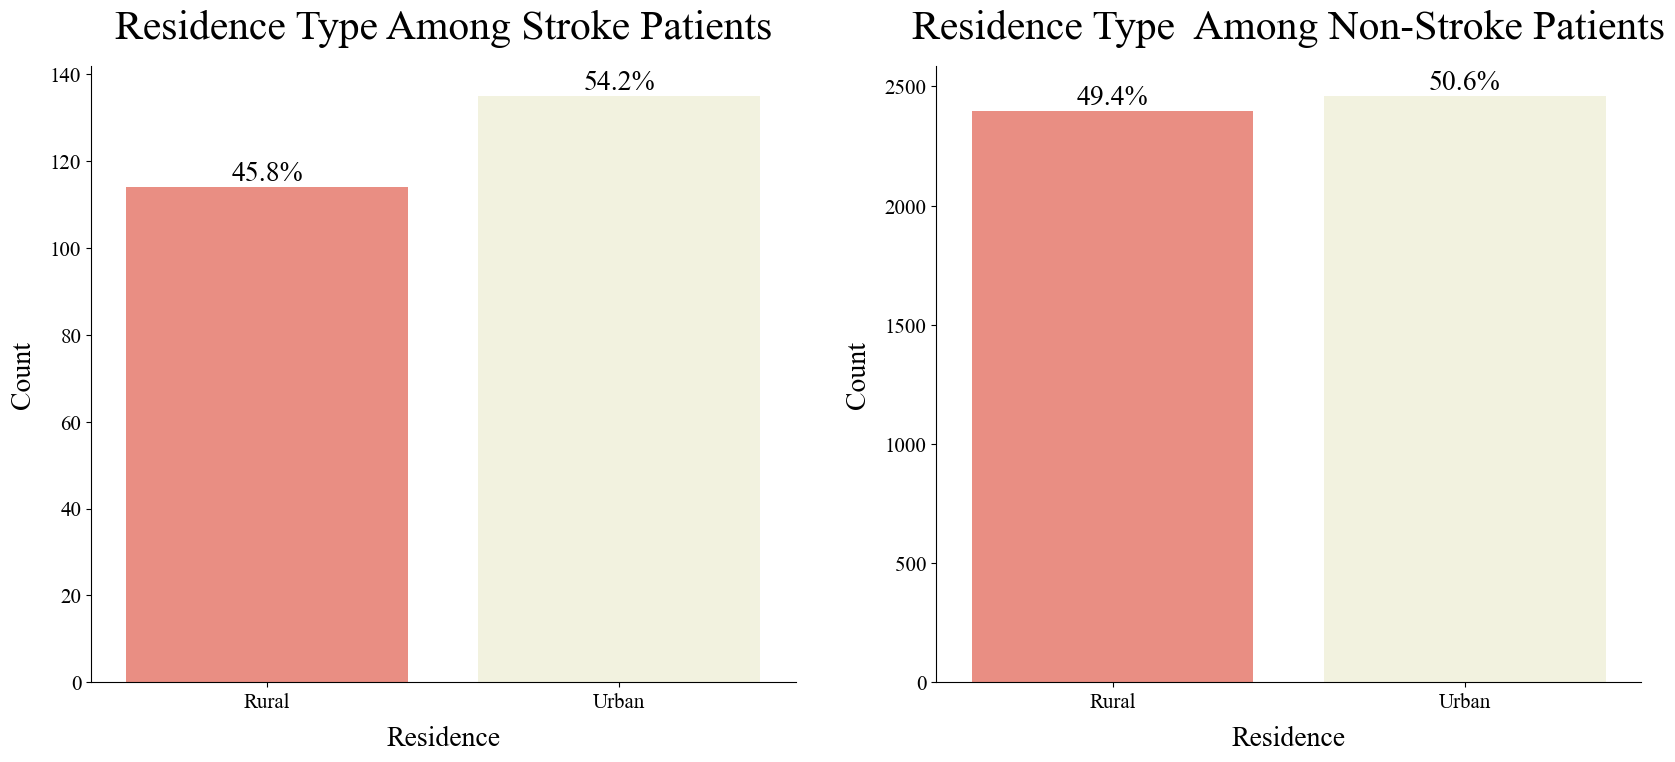

In [45]:
labels = ['Urban', 'Rural']
palette = [color_9, color_10]
y = 'Count'

data_1 = wi_stroke_residence
data_2 = no_stroke_residence
title_1 = 'Residence Type Among Stroke Patients'
title_2 = 'Residence Type  Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette)

### **Section Summary**
> * It seems that the place of residence (Urban or Rural) is not a significant factor.

## **Smoking Habits**

In [46]:
feature = 'Smoking'
target = 'Stroke'
data = data.copy()

In [47]:
wi_stroke_smoking = create_distributions(data, feature, target, value = 1)

In [48]:
no_stroke_smoking = create_distributions(data, feature, target, value = 0)

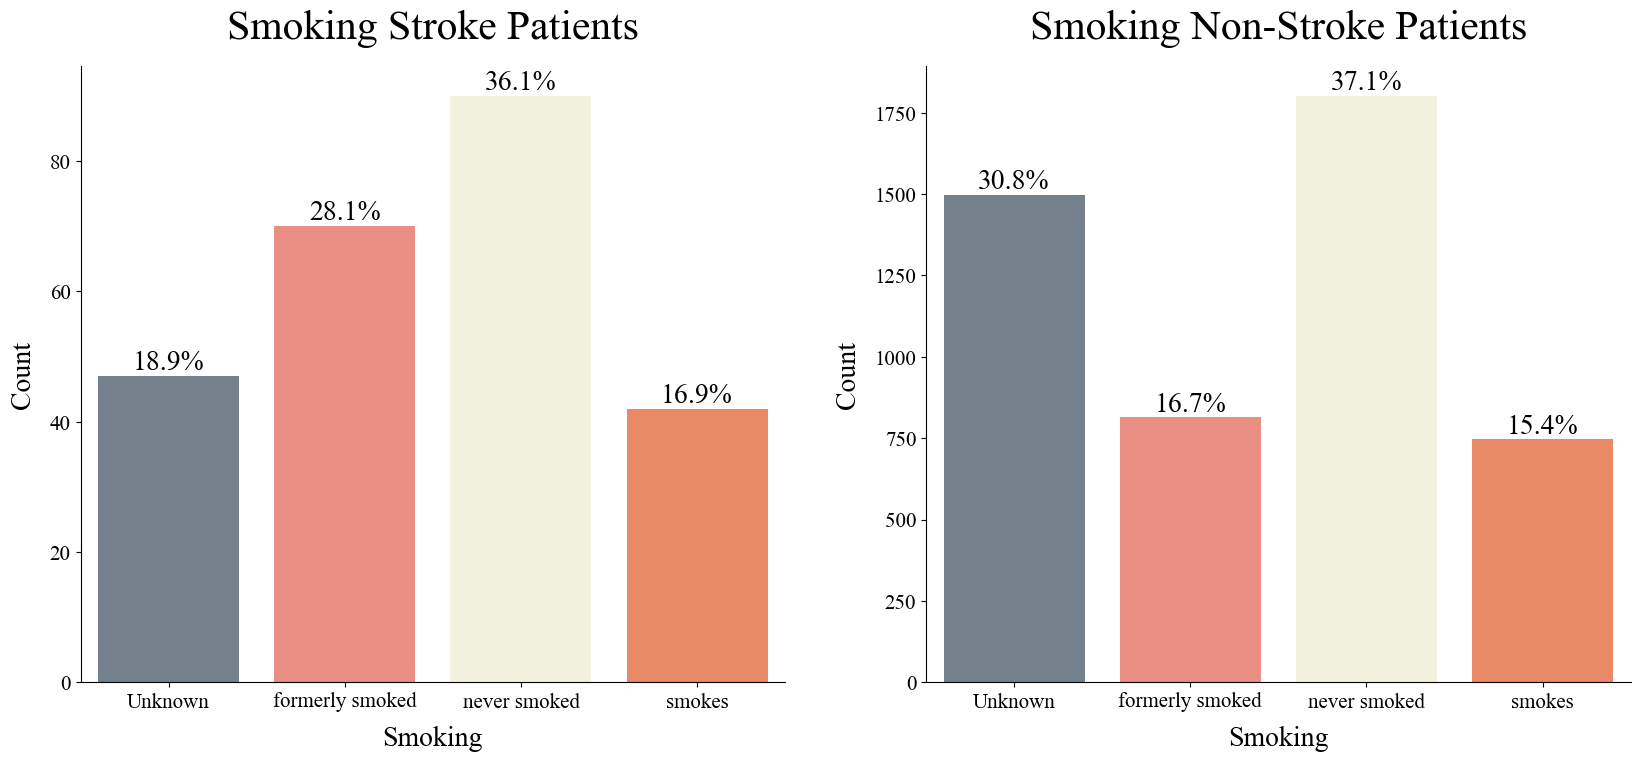

In [49]:
labels = ['formerly smoked', 'never smoked', 'smokes', 'Unknown']   
palette = [color_8, color_9, color_10, color_11]
y = 'Count'
data_1 = wi_stroke_smoking
data_2 = no_stroke_smoking
title_1 = 'Smoking Stroke Patients'
title_2 = 'Smoking Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, feature, y, palette)

### **Section Summary**
> * These figures seem interesting. 
> * Although a higher percentage of those who formerly smoked are in the stroke category, the percentage of current smokers are about the same in both groups. 
> * I did not expect that. I was sure that smoking will be a significant risk factor. 


## **Glucose Bins**

In [50]:
feature = 'AVG Glucose'
target = 'Stroke'
new_feature = 'Glucose Bins'

bins = [50, 100, 150, 200, 250, 300]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

In [51]:
df = data.copy()
data = create_bins(df, feature, new_feature, bins, labels)
data[new_feature] = data[new_feature].astype('object')

In [52]:
df = data[data[target] == 1].copy()
wi_stroke_glucose = count_bins(df, new_feature)

In [53]:
df = data[data[target] == 0].copy()
no_stroke_glucose = count_bins(df, new_feature)

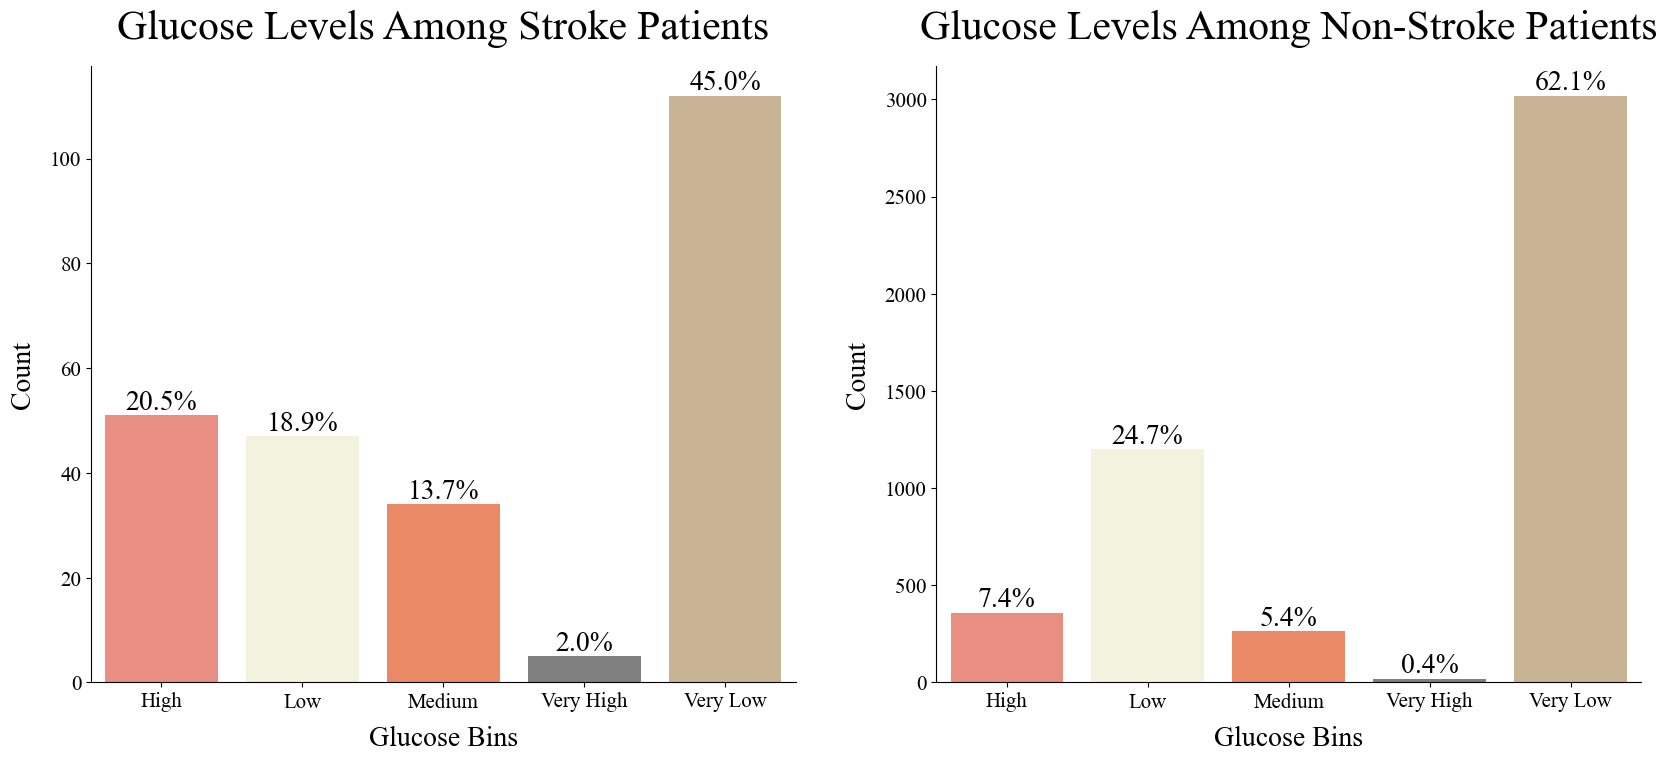

In [54]:
palette = [color_9, color_10, color_11, color_13, color_14]
y = 'Count'

data_1 = wi_stroke_glucose
data_2 = no_stroke_glucose
title_1 = 'Glucose Levels Among Stroke Patients'
title_2 = 'Glucose Levels Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, new_feature, y, palette)

### **Section Summary**
> * It seems that average glucose could be another risk factor contributing to stroke. 
> * 101 - 150: In this range, the average glucose levels of stroke and non-stroke patients do not seem to be very different. In fact, there is a slightly higher perectage of non-stroke patients at this glucose level.
> * 151 - 200: More than twice the percentage of stroke patients have this average glucose level.
> * 201 - 250: The percentage of stroke patients with this range of average glucose is nearly 3 times than those who did not suffer a stroke.


# **BMI Bins**

In [55]:
feature = 'BMI'
new_feature = 'BMI Bins'
bins = [10, 20, 30, 40, 50, 70]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

In [56]:
df = data.copy()
data = create_bins(df, feature, new_feature, bins, labels)
data[new_feature] = data[new_feature].astype('object')

In [57]:
df = data[data[target] == 1]
wi_stroke_BMI = count_bins(df, new_feature)

In [58]:
df = data[data[target] == 0]
no_stroke_BMI = count_bins(df, new_feature)

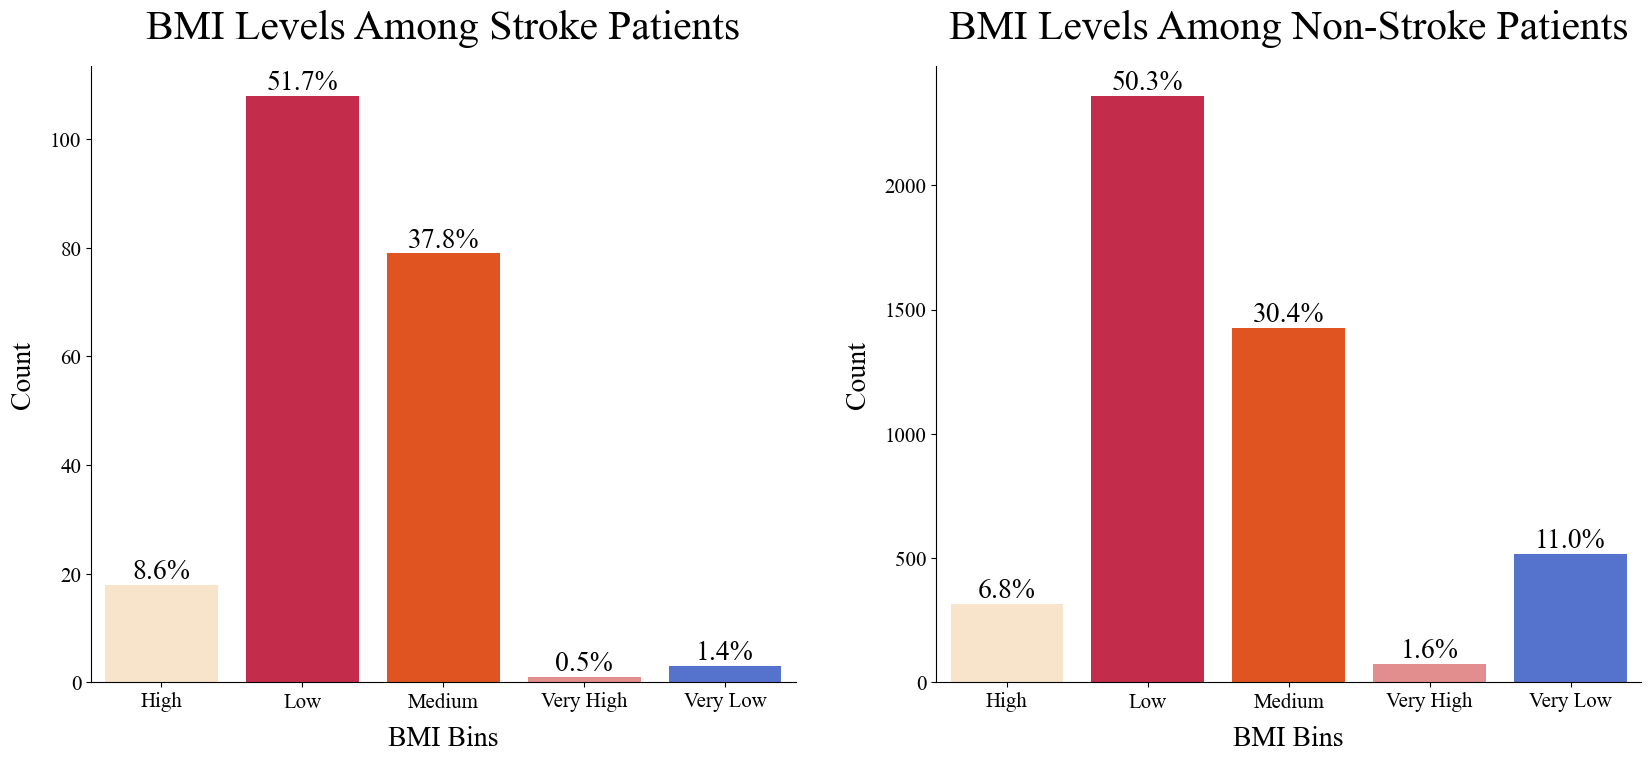

In [59]:
palette = [color_1, color_2, color_3, color_4, color_5,color_9, color_10, color_11, color_13, color_14]
y = 'Count'

data_1 = wi_stroke_BMI
data_2 = no_stroke_BMI
title_1 = 'BMI Levels Among Stroke Patients'
title_2 = 'BMI Levels Among Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, new_feature, y, palette)

### **Section Summary**
> * Except at the lowest BMI range of 11 - 20, stroke and non-stroke patients seem to be nearly identical in their BMI scores. 

## **Age Bins**

In [60]:
feature = 'Age'
new_feature = 'Age Bins'
bins = [0, 30, 50, 70, 80, 90]
labels = ['0-30', '30-50', '50-70', '70-80', '80-90']

In [61]:
df = data.copy()
data = create_bins(df, feature, new_feature, bins, labels)
data[new_feature] = data[new_feature].astype('object')

In [62]:
df = data[data[target] == 1]
wi_stroke_age = count_bins(df, new_feature)

In [63]:
df = data[data[target] == 0]
no_stroke_age = count_bins(df, new_feature)

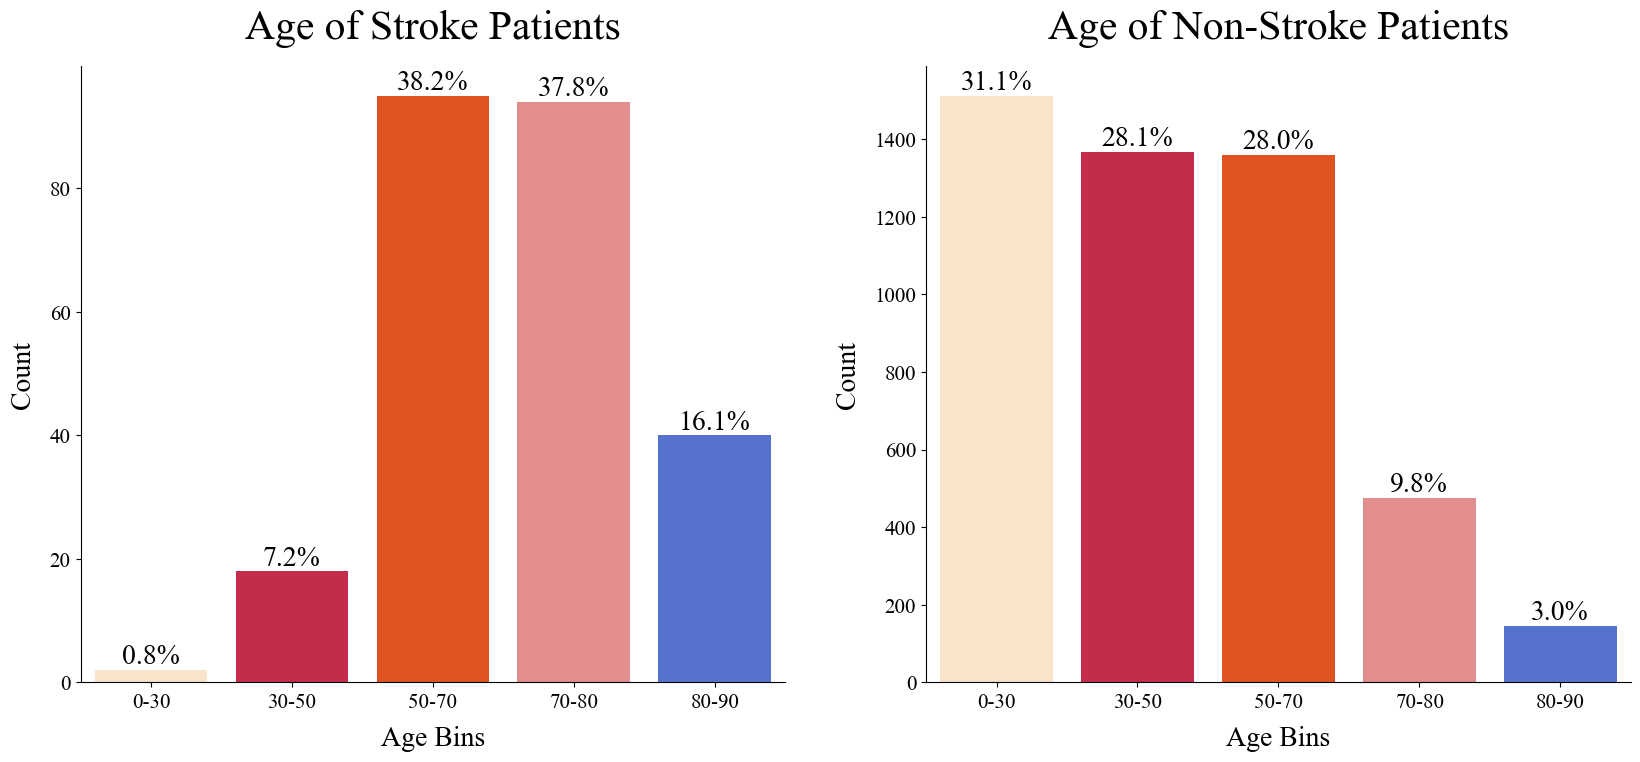

In [64]:
palette = [color_1, color_2, color_3, color_4, color_5,color_9, color_10, color_11, color_13, color_14]
y = 'Count'

data_1 = wi_stroke_age
data_2 = no_stroke_age
title_1 = 'Age of Stroke Patients'
title_2 = 'Age of Non-Stroke Patients'

side_by_side_barplot(data_1, data_2, title_1, title_2, labels, new_feature, y, palette)

### **Section Summary**
> * It is obvious that a higher percentage of younger people are in the non-stroke group. 
> * In the 60 - 70 range, the percentage of stroke sufferers is more than three times than that patients who did not suffer a stroke. 
> * This clearly shows the role of age in this affliction. 

# **Hypothesis Tests**

## **Hypothesis Test: Smoking Habits and Stroke** 

**Null**: There is no significant difference between the proporation of smokers who suffered a stroke and non-smokers.<BR>
**Alternative**: A higher proportion of smokers suffered a stroke compared to non-smokers. 

In [65]:
feature = 'Smoking'
target = 'Stroke'

In [66]:
smokers = data.loc[data[feature] == 'smokes']
count_smokers = smokers.shape[0]
count_smoker_stroke = (smokers[target] == 1).sum()
prop_smoker_stroke = count_smoker_stroke / count_smokers
print(
    f"Proportion of smokers who have suffered a stroke {prop_smoker_stroke:.3f}"
)

Proportion of smokers who have suffered a stroke 0.053


In [67]:
nonsmokers = data.loc[data[feature] == 'never smoked']
count_nonsmokers = nonsmokers.shape[0]
count_nonsmoker_stroke = (nonsmokers[target] == 1).sum()
prop_nonsmoker_stroke = count_nonsmoker_stroke / count_nonsmokers
print(
    f"Proportion of nonsmokers who have suffered a stroke {prop_nonsmoker_stroke:.3f}"
)

Proportion of nonsmokers who have suffered a stroke 0.048


In [68]:
numerator = np.array([count_smoker_stroke, count_nonsmoker_stroke])
denominator = np.array([count_smokers, count_nonsmokers])

stat, pval = proportions_ztest(numerator, denominator, alternative="two-sided")

print(f"The p-value is: {pval:.2f}")

if pval< 0.05:
    print("Null hypothesis is rejected.")
else:
    print("Failed to reject the null hypothesis.")

The p-value is: 0.54
Failed to reject the null hypothesis.


### **Section Summary**
> * This high p-value suggests that there is no significant evidence to reject the null hypothesis. In other words, any observed effect or difference is likely due to random chance rather than a true effect.
> * The p-value of 0.54 is above the significance level threshold of 0.05 in the Standards section of this project.
> * Based on this p-values, the null hypothesis is not rejected. 
> * This fits with our observations earlier when looking at percentage of smokers and non-smokers among patients who suffered a stroke and those who did not. 

## **Hypothesis Test: Mean Glucose Level and Stroke**

**Null**: There is no significant difference between the mean AVG Glucose of patients who suffered a stroke and patients who did not.<BR>
**Alternative**: The mean AVG Glucose of patients who suffered a stroke is significantly different than the mean AVG Glucose of patients who did not. 

In [69]:
feature = 'AVG Glucose'
target = 'Stroke'

In [70]:
no_stroke_glucose = data[data[target] == 0][feature]
wi_stroke_glucose = data[data[target] == 1][feature]

### **Numpy Variance Test**

In [71]:
var_non_stroke_glucose = np.var(no_stroke_glucose)
var_stroke_glucose = np.var(wi_stroke_glucose)

if var_non_stroke_glucose == var_stroke_glucose:
    variance = True
else:
    variance = False

### **Two-Sample T-Test**

In [72]:
pvalue = two_sample_t_test(no_stroke_glucose,wi_stroke_glucose, variance)

The variance of the samples are different.
The p-value is:  0.00000000002373124054
Null hypothesis is rejected.


### **Section Summary**
> * This low p-value suggests that there may be significant evidence to reject the null hypothesis. In other words, any observed effect or difference is not likely due to random chance alone and may a true effect.
> * This suggests that average glucose level could a significant risk factor for stroke and it goes with our earlier observation of average glucose levels in patients who suffered a stroke and those who did not. 

# **Preliminary Results**

In this section, I arrived at basepoint results to compare with results after feature engineering and hyperparameter tuning.

In [118]:
data_preliminary = data.copy()

In [119]:
data_preliminary.isnull().sum(axis=0)

ID                 0
Gender             0
Age                0
Hypertension       0
Heart Disease      0
Ever Married       0
Work               0
Residence          0
AVG Glucose        0
BMI              201
Smoking            0
Stroke             0
Glucose Bins       0
BMI Bins         205
Age Bins           0
dtype: int64

In [120]:
random_state = 101
target = 'Stroke'

### **Missing Indicator**

In [121]:
ami = AddMissingIndicator()
ami.fit(data_preliminary)
data_preliminary = ami.transform(data_preliminary)
data_preliminary.rename(columns={'BMI_na': 'BMI_NAN'}, inplace=True)
data_preliminary.rename(columns={'BMI Bins_na': 'BMI Bins_NAN'}, inplace=True)

### **Random Sample Imputer**

In [122]:
rsi = RandomSampleImputer()
rsi.fit(data_preliminary)
data_preliminary = rsi.transform(data_preliminary)

## **Eliminate White Space in Column Names**

In [124]:
data_preliminary.columns = [col.replace(' ', '_') for col in data_preliminary.columns]

### **Label Encoder**

In [125]:
label_encoder = LabelEncoder()
obj = data_preliminary.dtypes == "object"

for col in list(obj[obj].index):
    data_preliminary[col] = label_encoder.fit_transform(data_preliminary[col])

## **Train Test Split**

In [126]:
X = data_preliminary.drop(columns=[target])
y = data_preliminary[target]

X, y = shuffle(X, y, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

## **K-Fold Cross Validation**

In [127]:
columns_to_scale = ['Age', 'AVG_Glucose', 'BMI']
# columns_to_scale = data_preliminary.select_dtypes(include=['number']).columns.tolist()


scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), columns_to_scale)
    ],
    remainder='passthrough' 
)

svc_model = SVC(class_weight='balanced')
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc_model)
])


lg_model = LogisticRegression(class_weight='balanced')
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', lg_model)
])


cb_model = CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cb', cb_model)
])


xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])


lgbm_model = LGBMClassifier(class_weight='balanced', verbose=0)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])


pipelines = {
    "SVC": svc_pipeline,
    "lg": lg_pipeline,
    "cb": cb_pipeline,
    "xgb": xgb_pipeline,
    "lgbm": lgbm_model  
}

scorer = make_scorer(recall_score, pos_label=1)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=scorer)
    print(f"{name}: Mean Recall:  {scores.mean():.2f}")

SVC: Mean Recall:  0.26
lg: Mean Recall:  0.79
cb: Mean Recall:  0.58
xgb: Mean Recall:  0.17
lgbm: Mean Recall:  0.31


### **Section Summary**
> * in the prelimiinary results, Logistic Regression, with no feature engineering, or hyperparameter tuning arrived at 79% recall, which surpasses my standard of 75% recall.

# **Feature Engineering**

In this section, I create new features from existing ones in hopes of improving model performance.

In [128]:
data_engineered = data.copy()

### **Missing Indicator**

In [129]:
ami = AddMissingIndicator()
ami.fit(data_engineered)
data_engineered = ami.transform(data_engineered)
data_engineered.rename(columns={'BMI_na': 'BMI_NAN'}, inplace=True)
data_engineered.rename(columns={'BMI Bins_na': 'BMI Bins_NAN'}, inplace=True)

### **Random Sample Imputer**

In [130]:
rsi = RandomSampleImputer()
rsi.fit(data_engineered)
data_engineered = rsi.transform(data_engineered)

### **Sum Glucose / Age**

In [131]:
mf = MathFeatures(variables = ["AVG Glucose",'Age'], func = "sum")
mf.fit(data_engineered)
data_engineered= mf.transform(data_engineered)

### **Product Glucose / Age**

In [132]:
mf = MathFeatures(variables = ["AVG Glucose",'Age'], func = "prod")
mf.fit(data_engineered)
data_engineered= mf.transform(data_engineered)

### **Mean Glucose / Age**

In [133]:
mf = MathFeatures(variables = ["AVG Glucose",'Age'], func = "mean")
mf.fit(data_engineered)
data_engineered= mf.transform(data_engineered)

### **Hypertenstion OR Heart Disease**

In [134]:
data_engineered['Hypertension or Heart_Disease'] = data_engineered['Hypertension'] | data_engineered['Heart Disease']

### **Hypertenstion AND Heart Disease**

In [135]:
data_engineered['Hypertension and Heart_Disease'] = data_engineered['Hypertension'] & data_engineered['Heart Disease']

### **Label Encoder**

In [136]:
label_encoder = LabelEncoder()
obj = data_engineered.dtypes == "object"

for col in list(obj[obj].index):
    data_engineered[col] = label_encoder.fit_transform(data_engineered[col])

### **Correlation between each Feature and the Target Feature**

In [137]:
corr_matrix = data_engineered.corr(numeric_only=True)
corr_matrix['Stroke'].sort_values(ascending=False)

Stroke                            1.000000
Age Bins                          0.261003
prod_AVG Glucose_Age              0.246548
Age                               0.245239
mean_AVG Glucose_Age              0.208640
sum_AVG Glucose_Age               0.208640
Hypertension or Heart_Disease     0.171856
BMI_NAN                           0.141231
BMI Bins_NAN                      0.139000
Heart Disease                     0.134905
AVG Glucose                       0.131991
Hypertension                      0.127891
Ever Married                      0.108299
Hypertension and Heart_Disease    0.080759
BMI                               0.045309
Smoking                           0.028108
Residence                         0.015415
Gender                            0.009081
ID                                0.006430
Work                             -0.032323
BMI Bins                         -0.056901
Glucose Bins                     -0.074777
Name: Stroke, dtype: float64

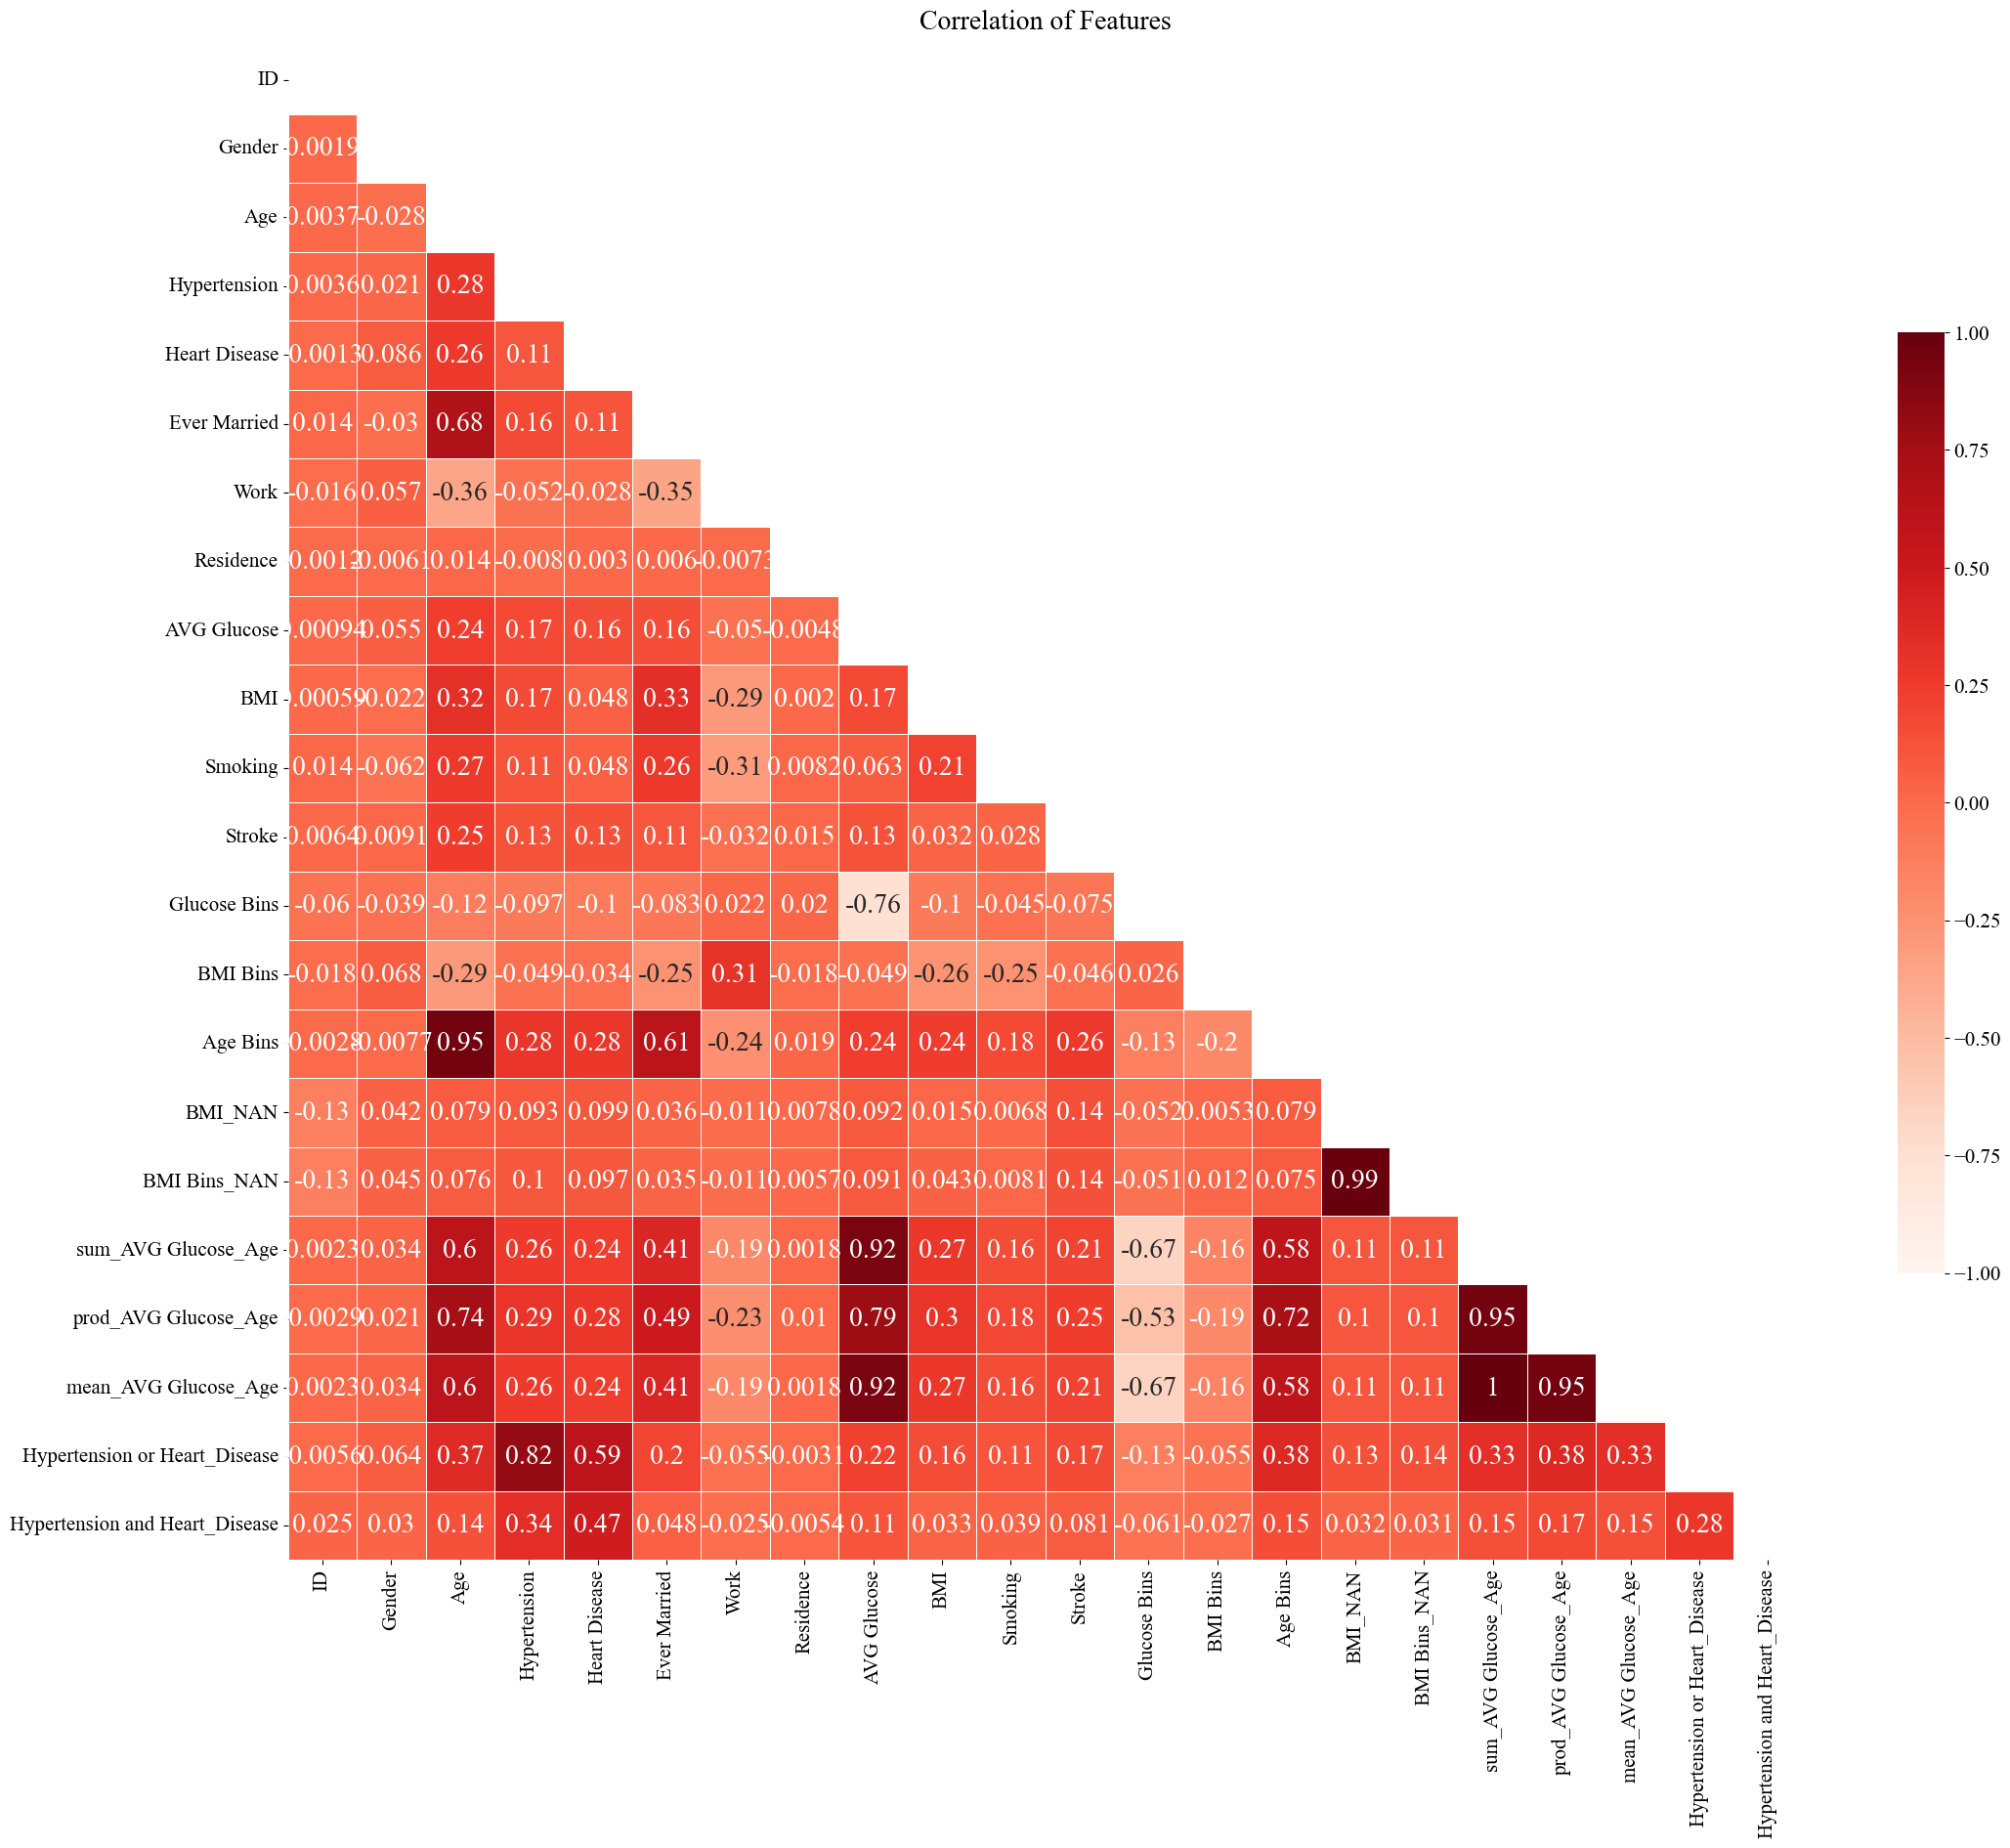

In [96]:
title = "Correlation of Features"
create_heatmap(data_engineered, title)

### **Drop Collinear Features**

In [138]:
dcf = DropCorrelatedFeatures(threshold=0.7)
data_engineered = dcf.fit_transform(data_engineered)

In [139]:
corr_matrix = data_engineered.corr(numeric_only=True)
corr_matrix['Stroke'].sort_values(ascending=False)

Stroke                            1.000000
Age                               0.245239
BMI Bins_NAN                      0.139000
Heart Disease                     0.134905
AVG Glucose                       0.131991
Hypertension                      0.127891
Ever Married                      0.108299
Hypertension and Heart_Disease    0.080759
BMI                               0.045309
Smoking                           0.028108
Residence                         0.015415
Gender                            0.009081
ID                                0.006430
Work                             -0.032323
BMI Bins                         -0.056901
Name: Stroke, dtype: float64

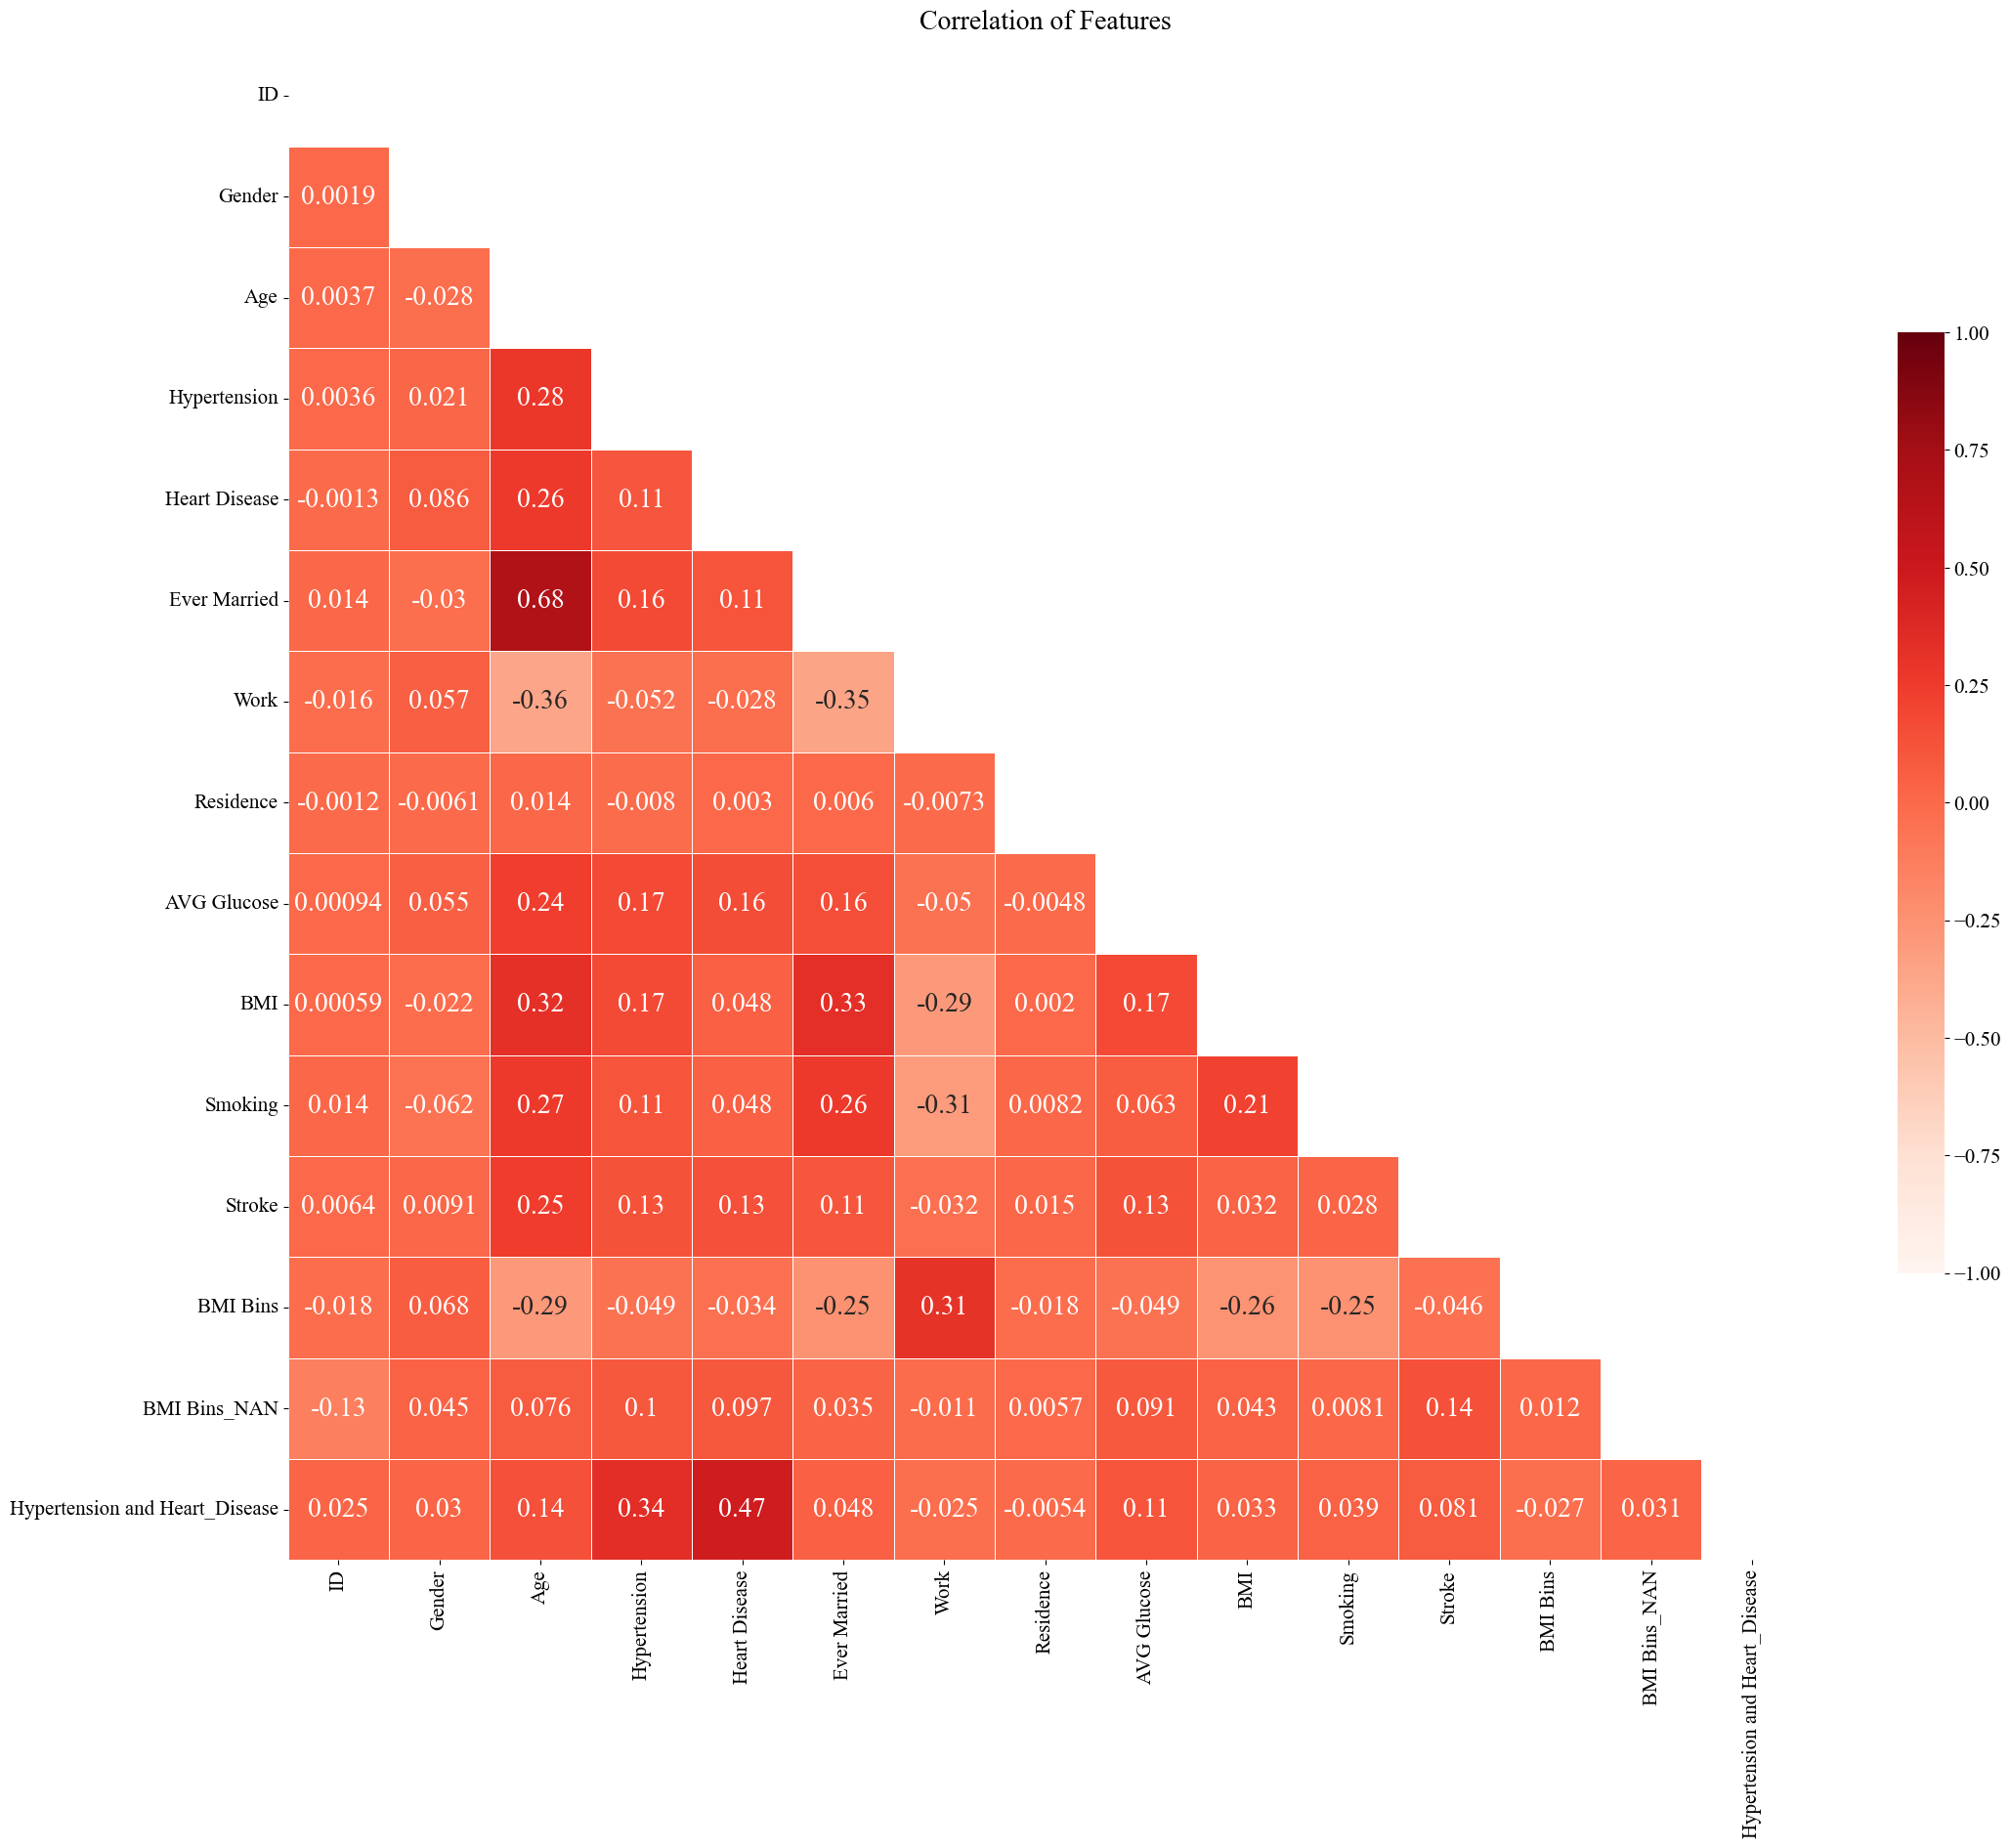

In [99]:
title = "Correlation of Features"
create_heatmap(data_engineered, title)

### **Mutual Information Plot**

This plot shows the predicitve power of each feature.

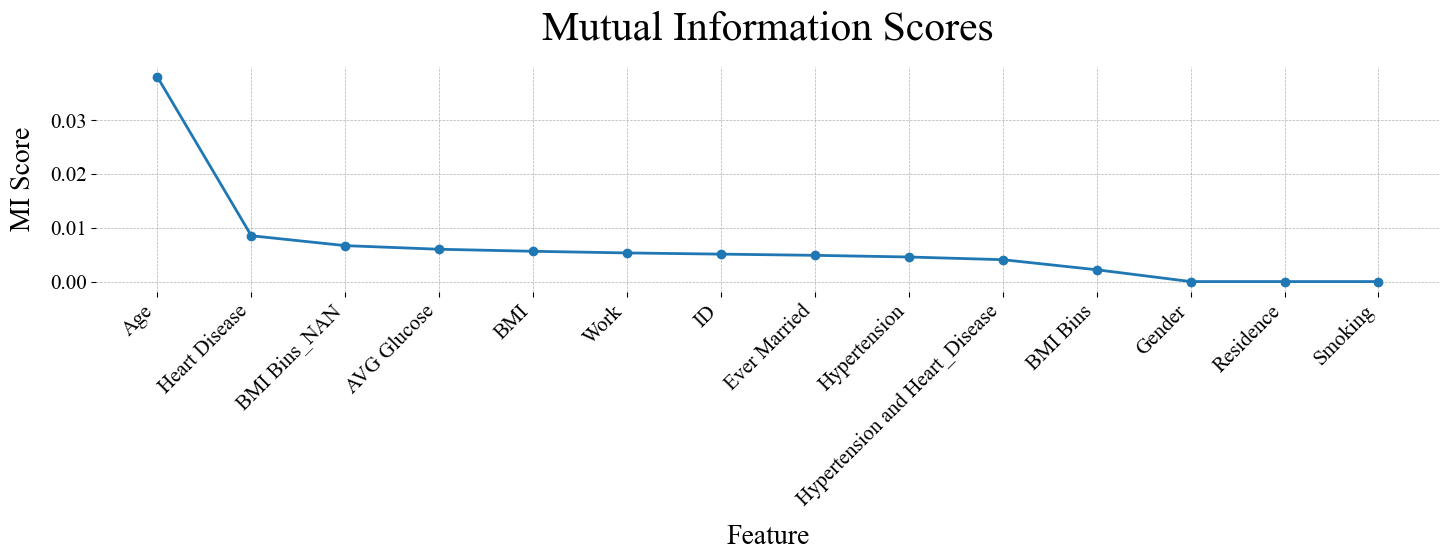

In [100]:
random_seed = 101

features = data_engineered.drop('Stroke', axis=1)
target = data_engineered['Stroke']

mi_scores = mutual_info_classif(features, target, random_state=random_seed)
create_plot_mi_scores(features, mi_scores)

### **Section Summary**
> * In this section, I dealth with missing values in the BMI and BMI related columns.
> * I created 5 additional features based on the existing features.
> * Using Feature Engine library, I dropped collinear features.
> * The mutual information column clearly identifies age as the major predictor of stroke.

# **Machine Learning**

## **Eliminate White Space in Column Names**

In [140]:
data_engineered.columns = [col.replace(' ', '_') for col in data_engineered.columns]

## **Train Test Split**

In [146]:
X = data_engineered.drop(columns=[target])
y = data_engineered[target]

X, y = shuffle(X, y, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=random_state)

## **K-Fold Cross Validation**

In [148]:
columns_to_scale = ['Age', 'AVG_Glucose', 'BMI']

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), columns_to_scale)
    ],
    remainder='passthrough' 
)

svc_model = SVC(class_weight='balanced')
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc_model)
])


lg_model = LogisticRegression(class_weight='balanced')
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', lg_model)
])


cb_model = CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cb', cb_model)
])


xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])


lgbm_model = LGBMClassifier(class_weight='balanced', verbose=0)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])


pipelines = {
    "SVC": svc_pipeline,
    "lg": lg_pipeline,
    "cb": cb_pipeline,
    "xgb": xgb_pipeline,
    "lgbm": lgbm_model  
}

scorer = make_scorer(recall_score, pos_label=1)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=scorer)
    print(f"{name}: Mean Recall:  {scores.mean():.2f}")

SVC: Mean Recall:  0.26
lg: Mean Recall:  0.81
cb: Mean Recall:  0.58
xgb: Mean Recall:  0.21
lgbm: Mean Recall:  0.31


### **Section Summary**
> * In this section, I used cross valildation to test 5 different models on the engineered dataset.
> * Logistic Regression surpassed the other models with an accuracy score of 81%, also surpasoing my standard accuracy score of 75%.

## **Patients Over Age 50**

In [149]:
data_overfifty = data_engineered[data_engineered['Age'] > 50]

### **Train Test Split**

In [150]:
X = data_overfifty.drop(columns=[target])
y = data_overfifty[target]

X, y = shuffle(X, y, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=random_state)

### **K-Fold Cross Validation**

In [151]:
columns_to_scale = ['Age', 'AVG_Glucose', 'BMI']

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), columns_to_scale)
    ],
    remainder='passthrough' 
)

svc_model = SVC(class_weight='balanced')
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc_model)
])


lg_model = LogisticRegression(class_weight='balanced')
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', lg_model)
])


cb_model = CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cb', cb_model)
])


xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])


lgbm_model = LGBMClassifier(class_weight='balanced', verbose=0)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])


pipelines = {
    "SVC": svc_pipeline,
    "lg": lg_pipeline,
    "cb": cb_pipeline,
    "xgb": xgb_pipeline,
    "lgbm": lgbm_model  
}

scorer = make_scorer(recall_score, pos_label=1)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=scorer)
    print(f"{name}: Mean Recall:  {scores.mean():.2f}")

SVC: Mean Recall:  0.46
lg: Mean Recall:  0.67
cb: Mean Recall:  0.47
xgb: Mean Recall:  0.17
lgbm: Mean Recall:  0.20


### **Section Summary**
> * In this section, I used cross valildation to test 5 different models on the engineered dataset on a dataset limited to patient over 50, since the data showed that these patients are more likely to suffer a stroke.
> * None of the models surpassed the accuracy score of 75%, also surpasoing my standard accuracy score of 75%.

## **Age, Hypertension, Heart Disease, Average Glucose**

In [152]:
columns_to_keep = ['Age', 'Hypertension', 'Heart_Disease','AVG_Glucose', 'Stroke']
data_age_HD_HY_GL = data_engineered[columns_to_keep]

### **Train Test Split**

In [153]:
X = data_age_HD_HY_GL.drop(columns=[target])
y = data_age_HD_HY_GL [target]

X, y = shuffle(X, y, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

### **K-Fold Cross Validation**

In [154]:
columns_to_scale = ['Age', 'AVG_Glucose']

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), columns_to_scale)
    ],
    remainder='passthrough' 
)

svc_model = SVC(class_weight='balanced')
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc_model)
])


lg_model = LogisticRegression(class_weight='balanced')
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', lg_model)
])


cb_model = CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cb', cb_model)
])


xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])


lgbm_model = LGBMClassifier(class_weight='balanced', verbose=0)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])


pipelines = {
    "SVC": svc_pipeline,
    "lg": lg_pipeline,
    "cb": cb_pipeline,
    "xgb": xgb_pipeline,
    "lgbm": lgbm_model  
}

scorer = make_scorer(recall_score, pos_label=1)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=scorer)
    print(f"{name}: Mean Recall:  {scores.mean():.2f}")

SVC: Mean Recall:  0.82
lg: Mean Recall:  0.79
cb: Mean Recall:  0.74
xgb: Mean Recall:  0.28
lgbm: Mean Recall:  0.47


### **Section Summary**
> * In this section, I used cross valildation to test 5 different models on the engineered dataset on a limited data set of 4 features only, the 4 features that showed the most predictive power of all the other ones.
> * Both Logistic Regression and SVC surpassed the other models with an accuracy score of 79% and 82% respectively, also surpasoing my standard accuracy score of 75%.

## **Age Only**

In [175]:
columns_to_keep = ['Age', 'Stroke']
data_age = data_engineered[columns_to_keep]

### **Train Test Split**

In [176]:
X = data_age.drop(columns=[target])
y = data_age [target]

X, y = shuffle(X, y, random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

### **K-Fold Cross Validation**

In [177]:
columns_to_scale = ['Age']

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), columns_to_scale)
    ],
    remainder='passthrough' 
)

svc_model = SVC(class_weight='balanced')
svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc_model)
])


lg_model = LogisticRegression(class_weight='balanced')
lg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lg', lg_model)
])


cb_model = CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')
cb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cb', cb_model)
])


xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('xgb', xgb_model)
])


lgbm_model = LGBMClassifier(class_weight='balanced', verbose=0)
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', lgbm_model)
])


pipelines = {
    "SVC": svc_pipeline,
    "lg": lg_pipeline,
    "cb": cb_pipeline,
    "xgb": xgb_pipeline,
    "lgbm": lgbm_model  
}

scorer = make_scorer(recall_score, pos_label=1)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=scorer)
    print(f"{name}: Mean Recall:  {scores.mean():.2f}")

SVC: Mean Recall:  0.86
lg: Mean Recall:  0.80
cb: Mean Recall:  0.82
xgb: Mean Recall:  0.78
lgbm: Mean Recall:  0.78


## **Age Feature with Tuned SVC Hyperparameters**

In [178]:
columns_to_scale = ['Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), columns_to_scale)
    ],
    remainder='passthrough' 
)

svc_model_optimized = SVC(kernel='linear', gamma='auto', C=0.1, class_weight='balanced')
svc_pipeline_optimized = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', svc_model)
])



pipelines = {
    "SVC": svc_pipeline_optimized,
}

scorer = make_scorer(recall_score, pos_label=1)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=10, scoring=scorer)
    print(f"{name}: Mean Recall:  {scores.mean():.2f}")

SVC: Mean Recall:  0.86


### **Section Summary**
> * In this section, I used cross valildation to test 5 different models on the engineered dataset with ONLY ONE FEATURE: Age.
> * This was the best performing model. Logistic Regression, SVC and CAT Boost all surpassed the other models with a accuracy scores of 80%, 86% and 82% respectively, also surpasoing my standard accuracy score of 75%.
> * Using randomized Grid Search, I tried to fine tune the hyperparameters of the SVC model to obtain even a better performance. The results I obtained were the same, 86%.

### **Section Summary**
> * In this section, I used cross valildation to test 5 different models on the engineered dataset with ONLY ONE FEATURE: Age.
> * This was the best performing model. Logistic Regression, SVC and CAT Boost all surpassed the other models with a accuracy scores of 80%, 86% and 82% respectively, also surpasoing my standard accuracy score of 75%.

### **SVC Pipeline Optimized**

In [179]:
svc_pipeline_optimized.fit(X, y)

recall_scorer = make_scorer(recall_score)
cv_results = cross_validate(svc_pipeline_optimized, X, y, cv=5, scoring={'recall': recall_scorer})

print("Recall scores for each fold:", cv_results['test_recall'])
print("Mean recall score:", cv_results['test_recall'].mean())

Recall scores for each fold: [0.88       0.88       0.9        0.76       0.87755102]
Mean recall score: 0.8595102040816327


### **Classification Report**

In [180]:
y_pred = svc_pipeline_optimized.predict(X_test)
recall = recall_score(y_test, y_pred)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.79       977
           1       0.10      0.84      0.18        45

    accuracy                           0.66      1022
   macro avg       0.54      0.75      0.48      1022
weighted avg       0.95      0.66      0.76      1022



### **Confusion Matrix**

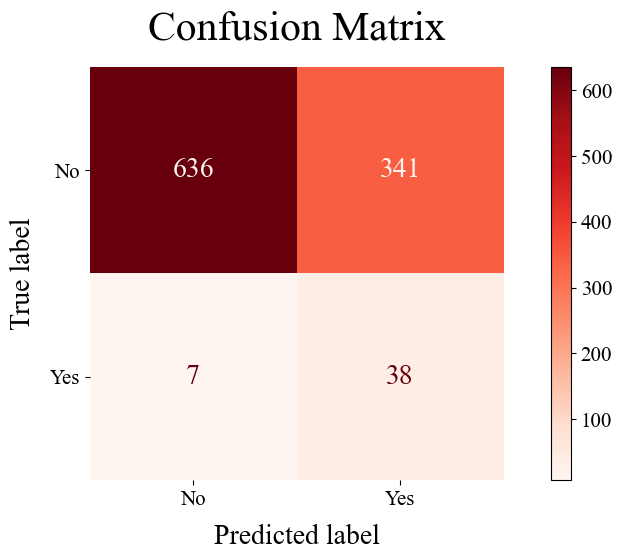

In [181]:
conf_matrix = ConfusionMatrixDisplay.from_estimator (svc_pipeline_optimized, X_test, y_test, cmap=plt.cm.Reds)

conf_matrix.ax_.set_xticks([0, 1])
conf_matrix.ax_.set_xticklabels(["No", "Yes"])
conf_matrix.ax_.set_yticks([0, 1])
conf_matrix.ax_.set_yticklabels(["No", "Yes"])

plt.title('Confusion Matrix')
plt.show()

# **Create a Pickle File for Stremlit Deployment**

# **Conclusions**

Here is a summary of the conclusions that may be drawn from this report. 

>* **The Analysis of the Data:** I reviewed over 5,000 datapoint related to patients with stroke. <br> 
>* **The Goal of the Project:** The goal of this project was to find a model that could predict if a patient is likely to have a stroke with a recall score of 0.75 or higher.<br>
>* **Models:** I utilized numerous models and numerous ways to hyperparameter tuning.  I chose two simple models, Logistic Regressin and Support Vector Machines. I chose three boosting classifiers, CAT, LGBM and XGB.<br>
>* **Encoding:** For categorical data, I tried both Label Encoding and One-Hot Encoding. I did not see significant differences. I chose Label Encoding since the resulting table was more readable.  <br>
>* **Imputing Missing Data:** For imputing missing data, I tried mean, median, zero and random imputers. I saw no signinficant difference between them in the predictions of my models. I chose Randmo Imputer, since it I thought with such little information about the participants, it makes no sense to make any judgments about their features.  <br>
>* **Feature Engineering and Hyperparameter Testing:** I tried feature engineering and hyperparameter testing with techniques such as Backward Elimination, SHAP and OPTUNA. Some, I included in this report and some I didn't for sake of brevity. None of the measures I utilized improved resutls significanlty.<br> 
>* **Support Vector Machines:** For a simple model and using only default hyperparameters, SVC was able to get better or similar results than any other model, including the more complex ones.<br>  
>* **Boosting Models:** Of the boosting models that I utilized, none of them performed better than SVC.
>* **Age:** In the end, the only feature that could predict suffering a stroke was age. No other combination of features, including features that I created from other features, was a better predictor than age. This shows the real short comings of the data itself that I mentioned in the secton below: "Suggestions for Improvment."
>* **Recommendation:** I am not able to make any medical recommendations based on this data. However, some obvious elements that I was sure would contribute to the risk of stroke such as smoking or BMI, turned out to be a very poor predictors. <br> 

# **Suggestions for Improvement**

This report has certain weaknesses. In this section, I outlined those weaknesses and indicated some avenues for improvement. 

>* **Domain Knowledge:** It is best if the data scientist has adequate domain knowledge on the topic of the analysis. I do not have any expertise in the medical field. There may be parts of the data that I have overlooked that may have been important and I may have given importance to parts that may have had little significance. <br>
>* **More Detailed Data:** The data provide only general information on patients. This information is not adequate to predict a disease as complex as stroke. Information such as family history, genetic markers, blood trace element markers and more are missing in this data. More detailed information could have helped make better predictions. <br>  
>* **Balance:** The data is heavely imbalanced. Of the more than 5,000 datapoints, only about 300 are related to stroke patients. This, in addition to inadequcy of the data as mentioned above adds to the complexity predictions.  <br>  
>* **Visualizations:** If I had more time, I would improve on the bar graphs to emphasize certain data by using specific colors.  <br>  
>* **Functions:** I modularized most of the code in this notebook but not all due to limitation of time.  <br>  
>* **Statistics:** Continue to improve my statistical knowledge to create better analyses.<br>
>* **Pandas:** Continue to learn to utilize more optimized Pandas techniques and algorithms.<br>
>* **Seaborn and Matplotlib:** Continue to improve my knowledge of Seaborn and Matplotlib for creating visualizations. <br>
>* **Python Code:** Continue to write better and more efficient Python code. <br>
>* **Clean Code:** Continue to adhere to the principles of writing clean code. <br>
>* **Readability and Efficiency:** Continue to improve my skills to find the delicate balance between readability and efficiency in coding.<br>
>* **Functions File:** For my next project, I will create a file with my functions, separate from the notebook file, to keep the notebook as a more reasonable length.<br>